In [194]:
# IMPORT ALL RELEVENT MODULES
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import pubchempy as pcp
import reportlab

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Descriptors
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from reportlab.lib.units import inch


Water_coreactant = AllChem.MolFromSmiles('O')

In [193]:
print("Pandas:",pd.__version__)
print("Numpy:",np.__version__)
print("RE:", re.__version__)
print("Matplotlib:",plt.matplotlib.__version__)
print("RDKit:", rdkit.__version__)
print("ReportLab:", reportlab.__version__)
print("PubChem Python:", pcp.__version__)
print("OS:",os.__file__)

Pandas: 1.5.1
Numpy: 1.25.0
RE: 2.2.1
Matplotlib: 3.7.1
RDKit: 2022.09.1
ReportLab: 4.0.4
PubChem Python: 1.0.4
OS: C:\Users\15099\anaconda3\envs\python3.9\lib\os.py


# Overview of program
## Supplemental data used and generated by this program

In [3]:
#Supplemental Code 1 Terpenoid Deconstruction Program

### DATASET(S) INTENDED AS INPUT FOR THIS CODE
# Dataset_S1.xlsx (Johnson et al.2019 doi: https://doi.org/10.1074/jbc.RA118.006025)
# Supplemental_Data.1a.DNP_Diterpene_Mining_v30.2.csv
# Supplemental_Data.1b.TeroKit_Diterpene_v2.0.tsv
# Supplemental_Data.1c.TeroKit_Triterpene_v2.0.tsv
# Supplemental_Data.1d.TeroKit_Sesquiterpene_v2.0.tsv)

### SUPPLEMENTAL DATASETS GENERATED BY THIS FUNCTION (GENERATION OF BACKBONE AND SKELETON INFORMATION)
# Supp.2a.DNP_Diterpene_Mining_v30.2_Updated_Skeleton_Backbone.tsv
# Supp.2b.TeroKit_Diterpene_v2.0_Updated_Skeleton_Backbone.tsv
# Supp.2c.TeroKit_Triterpene_v2.0_Updated_Skeleton_Backbone.tsv
# Supp.2d.TeroKit_Sesquiterpene_v2.0_Updated_Skeleton_Backbone.tsv
# Supp.2e.DNP_Diterpene_Skeleton_Summary.tsv
# Supp.2f.TeroKit_Diterpene_Skeleton_Summary.tsv
# Supp.2g.Diterpene_Skeleton_Abundance_Distribution.png
# Supp.2h.Diterpene_Deconstructed_Skeleton_Carbon_Distribution.png
# Supp.2i.10X_Zoomed__Diterpene_Deconstructed_Skeleton_Carbon_Distribution.png

'''
### OVERVIEW OF FUNCTIONALITIY ###
### Davis Mathieu
### Jan 1, 2024

This program functions to take a large dataset containing terpenoids
and revert them to their terpene backbones and terpene skeletons. We
define a terpene backbone as the stripped terpenoid structure of all 
functional groups, breaking any oxygen linkages with the aim to 
return just the (cyclized) isoprene derived ring structure (based on
retained carbon-carbon linkages), but retaining double bond variation,
stereochemical variation, and hydroxyl groups present where functional
groups once were. The terpene skeletons take this one step further and 
strip all stereochemistry, bond variation, and hydroxyl groups, leaving
exclusively the "flattened" carbon-carbon linkages, exclusively. This
program is intended to take mined DNP data (found from Johnson et al.
2019 doi: https://doi.org/10.1074/jbc.RA118.006025) Dataset_S1.xlsx with
InChis converted to SMILEs using Obabel and updated to a newer version 
(Supplemental_Data.1a.DNP_Diterpene_Mining_v30.2.csv) as well as the 
table formatted acquired from bulk download on TeroKit 
(http://terokit.qmclab.com/data.html).

Functions:
- Deconstruct2backbone: Takes a terpene in SMILE format and strips
                        functional groups to return the terpene 
                        backbone and the list of all steps taken to
                        deconstruct the molecule.

- backbone_flattener:   Takes the deconstructed backbone and strips
                        all stereochemistry, double bonds, triple 
                        bonds, aromatics, and hydroxyl groups.
                        
These produce updated information on terpene backbones, skeletons,
database deconstruction information (final carbon numbers), and 
skeleton distribution.                    
'''
x=0

## Deconstruction Rules Function

In [4]:
def deconstruct2backbone(sub):
    The_Process = [sub]
    #sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub), sanitize=False)
    sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
    

    """
    Remove Fatty Acids
    """        
    fatty_acid_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:21]!@[#8:0]!@[#6:1]!@[#6:2]!@[#6:3]!@[#6:4]!@[#6:5]!@[#6:6]!@[#6:7]!@[#6:8]!@[#6:9]!@[#6:10]!@[#6:11]!@[#6:12]!@[#6:13]!@[#6:14]!@[#6:15]!@[#6:16]!@[#6:17]!@[#6:18]"))
    while(fatty_acid_present):
        remove_fatty_acid = AllChem.ReactionFromSmarts("[#6:21]!@[#8:0]!@[#6:1]!@[#6:2]!@[#6:3]!@[#6:4]!@[#6:5]!@[#6:6]!@[#6:7]!@[#6:8]!@[#6:9]!@[#6:10]!@[#6:11]!@[#6:12]!@[#6:13]!@[#6:14]!@[#6:15]!@[#6:16]!@[#6:17]!@[#6:18]>>[#6:21][#8:0].[#6:1][#6:2][#6:3][#6:4][#6:5][#6:6][#6:7][#6:8][#6:9][#6:10][#6:11][#6:12][#6:13][#6:14][#6:15][#6:16][#6:17][#6:18]")
        sub1=remove_fatty_acid.RunReactants((sub,))[0][0]
        if(re.search("CCCCCCCCCC", Chem.MolToSmiles(remove_fatty_acid.RunReactants((sub,))[0][1]))):
            sub=Chem.MolFromSmiles(Chem.MolToSmiles(sub1))
            fatty_acid_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:21]!@[#8:0]!@[#6:1]!@[#6:2]!@[#6:3]!@[#6:4]!@[#6:5]!@[#6:6]!@[#6:7]!@[#6:8]!@[#6:9]!@[#6:10]!@[#6:11]!@[#6:12]!@[#6:13]!@[#6:14]!@[#6:15]!@[#6:16]!@[#6:17]!@[#6:18]"))
        else:
            fatty_acid_present = []
        The_Process.append(sub)

    glucose_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]-1(-[#8:8][#6:15])[#8:3][#6:4](-[#6:9][#8:10])[#6:5](-[#8:11])[#6:6](-[#8:12])[#6:7](-[#8:13])-1"))
    while(len(glucose_present) > 0):
        condition =""
        rxn4 = AllChem.ReactionFromSmarts("[#6:1]-1(-[#8:8][#6:15])[#8:3][#6:4](-[#6:9][#8:10])[#6:5](-[#8:11])[#6:6](-[#8:12])[#6:7](-[#8:13])-1.[#8:14]>>[#6:15][#8:14].[#6:1]-1(-[#8:8])[#8:3][#6:4](-[#6:9][#8:10])[#6:5](-[#8:11])[#6:6](-[#8:12])[#6:7](-[#8:13])-1")
        sub1 = rxn4.RunReactants((sub,Water_coreactant))
        for i in sub1:
            #print(CalcMolFormula(Chem.MolFromSmiles(Chem.MolToSmiles(i[1]))))
            if(Chem.MolFromSmiles(Chem.MolToSmiles(i[1]))==None):
                condition=""
            elif(CalcMolFormula(Chem.MolFromSmiles(Chem.MolToSmiles(i[1])))=="C6H12O6"):
                condition="skip"
                sub= i[0]; break
            elif(CalcMolFormula(Chem.MolFromSmiles(Chem.MolToSmiles(i[1])))=="C18H32O15"):
                condition="skip"
                sub= i[0]; break
            elif(CalcMolFormula(Chem.MolFromSmiles(Chem.MolToSmiles(i[1])))=="C18H32O14"):
                condition="skip"
                sub= i[0]; break
            elif(int(re.findall("\d+",CalcMolFormula(Chem.MolFromSmiles(Chem.MolToSmiles(i[0]))))[0])%5==0):
                condition="skip"
                sub=i[0];break
            elif(int(re.findall("\d+",CalcMolFormula(Chem.MolFromSmiles(Chem.MolToSmiles(i[0]))))[0])==19):
                condition="skip"
                sub=i[0];break
            elif(len(re.findall("S",CalcMolFormula(Chem.MolFromSmiles(Chem.MolToSmiles(i[1])))))>0):
                condition="skip"
                sub=i[0];break
        if(condition=="skip"):
            condition==""
        elif(len(re.findall("C",Chem.MolToSmiles(sub1[0][0]),re.IGNORECASE))<len(re.findall("C",Chem.MolToSmiles(sub1[0][1]),re.IGNORECASE))):
            if(Chem.MolFromSmiles(Chem.MolToSmiles(sub1[0][1]))!=None and CalcMolFormula(Chem.MolFromSmiles(Chem.MolToSmiles(sub1[0][1])))!="C6H12O6" and len(re.findall("C",Chem.MolToSmiles(sub1[0][1]),re.IGNORECASE))>len(re.findall("C",Chem.MolToSmiles(sub1[0][0]),re.IGNORECASE))):
                sub=sub1[0][1]
            elif(Chem.MolFromSmiles(Chem.MolToSmiles(sub1[0][0]))!=None and CalcMolFormula(Chem.MolFromSmiles(Chem.MolToSmiles(sub1[0][0])))!="C6H12O6"):
                sub=sub1[0][0]
            else:
                break
        else:
            sub = sub1[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        glucose_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]-1(-[#8:8][#6:15])[#8:3][#6:4](-[#6:9][#8:10])[#6:5](-[#8:11])[#6:6](-[#8:12])[#6:7](-[#8:13])-1"))
        The_Process.append(sub) 

    sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
    C13_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]!@[13#6H]"))
    if(len(C13_present)>0):
        sub =str(Chem.MolToSmiles(sub))
        sub = re.sub("\[13CH3\]","C",sub)
        sub = re.sub("\[13CH2\]","C",sub)
        sub = re.sub("\[13CH\]","C",sub)
        sub = re.sub("\[13C\]","C",sub)
        sub = Chem.MolFromSmiles(sub)

    sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
    C14_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]!@[14#6H]"))
    if(len(C14_present)>0):
        sub =str(Chem.MolToSmiles(sub))
        sub = re.sub("\[14CH3\]","C",sub)
        sub = re.sub("\[14CH2\]","C",sub)
        sub = re.sub("\[14CH\]","C",sub)
        sub = re.sub("\[14C\]","C",sub)
        sub = Chem.MolFromSmiles(sub)
        
    carbocation_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6+:1]"))
    if(len(carbocation_present)>0):
        sub= str(Chem.MolToSmiles(sub))
        sub = re.sub("\[CH2\+\]", "C",sub)
        sub = re.sub("\[CH\+\]", "C",sub)
        sub = re.sub("\[C\+\]", "C",sub)
        sub = Chem.MolFromSmiles(sub)

    carbanion_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6-:1]"))
    if(len(carbanion_present)>0):
        sub = str(Chem.MolToSmiles(sub))
        sub = re.sub("\[CH2\-\]", "C",sub) 
        sub = re.sub("\[CH\-\]", "C",sub)
        sub = re.sub("\[C\-\]", "C",sub)
        sub = Chem.MolFromSmiles(sub)

 
    glucose_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]-1[#8:2][#6:3](-[#6:4]-[#6:5](=[#8:6])-[#8:7])[#6:8](-[#8:9])[#6:10](-[#8:11])[#6:12](-[#8:13])-1"))
    while(len(glucose_present)>0):
        remove_glucose = AllChem.ReactionFromSmarts("[#6:1]-1[#8:2][#6:3](-[#6:4]-[#6:5](=[#8:6])-[#8:7])[#6:8](-[#8:9])[#6:10](-[#8:11])[#6:12](-[#8:13])-1>>[#8:7].[#6:1]-1[#8:2][#6:3](-[#6:4]-[#6:5](=[#8:6]))[#6:8](-[#8:9])[#6:10](-[#8:11])[#6:12](-[#8:13])-1")
        sub = remove_glucose.RunReactants((sub,))[0][0]
        glucose_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]-1[#8:2][#6:3](-[#6:4]-[#6:5](=[#8:6])-[#8:7])[#6:8](-[#8:9])[#6:10](-[#8:11])[#6:12](-[#8:13])-1"))
        The_Process.append(sub)
           
    pentopyranose_sugar_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1](-[#8:2][#6:11])(-[#8:3]-1)[#6:4](-[#8:5])[#6:6](-[#8:7])[#6:8](-[#8:9])[#6:10]-1"))
    while(len(pentopyranose_sugar_present) > 0):
        rxn7 = AllChem.ReactionFromSmarts("[#6:1](-[#8:2][#6:11])(-[#8:3]-1)[#6:4](-[#8:5])[#6:6](-[#8:7])[#6:8](-[#8:9])[#6:10]-1>>[#8:2][#6:11].[#6:1](-[#8:3]-1)[#6:4](-[#8:5])[#6:6](-[#8:7])[#6:8](-[#8:9])[#6:10]-1")
        sub1 = rxn7.RunReactants((sub,))
        if(len(re.findall("C",Chem.MolToSmiles(sub1[0][0]), re.IGNORECASE))<len(re.findall("C",Chem.MolToSmiles(sub1[0][1]), re.IGNORECASE))):
            sub = sub1[0][1]
        else:
            sub = sub1[0][0]
        pentopyranose_sugar_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1](-[#8:2][#6:11])(-[#8:3]-1)[#6:4](-[#8:5])[#6:6](-[#8:7])[#6:8](-[#8:9])[#6:10]-1"))
        #print("pentopyranose present")
        The_Process.append(sub)

    furan_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1][#6:2]-1=[#6:3](-[#8:4])[#6:5](=[#8:6])-[#8:7][#6:8](-[#8:9])-1"))
    while(len(furan_present)>0):
        rxn_8 = AllChem.ReactionFromSmarts("[#6:1][#6:2]-1=[#6:3](-[#8:4])[#6:5](=[#8:6])-[#8:7][#6:8](-[#8:9])-1>>[#6:1].[#6:2]-1=[#6:3](-[#8:4])[#6:5](=[#8:6])-[#8:7][#6:8](-[#8:9])-1")
        sub = rxn_8.RunReactants((sub,))[0][0]
        furan_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1][#6:2]-1=[#6:3](-[#8:4])[#6:5](=[#8:6])-[#8:7][#6:8](-[#8:9])-1"))
        The_Process.append(sub)
      
    furanose_sugar_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#8:1]-1-[#6:2](-[#8:3][#6:11])[#6:4](-[#8:5])[#6:6](-[#8:7])-[#6:8]-1(-[#6:9][#8:10])"))
    while(len(furanose_sugar_present) > 0):
        rxn8 = AllChem.ReactionFromSmarts("[#8:1]-1-[#6:2](-[#8:3][#6:11])[#6:4](-[#8:5])[#6:6](-[#8:7])-[#6:8]-1(-[#6:9][#8:10]).[#8:12]>>[#6:11][#8:12].[#8:1]-1-[#6:2](-[#8:3])[#6:4](-[#8:5])[#6:6](-[#8:7])-[#6:8]-1(-[#6:9][#8:10])")
        sub = rxn8.RunReactants((sub,Water_coreactant))[0][0]
        furanose_sugar_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#8:1]-1-[#6:2](-[#8:3][#6:11])[#6:4](-[#8:5])[#6:6](-[#8:7])-[#6:8]-1(-[#6:9][#8:10])"))
        #print("furanose present")
        The_Process.append(sub)
   

    coumarin_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]:1(-[#8:7]):[#6:2]:[#6:3]:[#6:4]:[#6:5]:2:[#6:6]:1:[#8:8]:[#6:9](=[#8:10]):[#6:11]:[#6:12]:2"))
    while(len(coumarin_present) > 0):
        rxn6 = AllChem.ReactionFromSmarts("[#6:1]:1(-[#8:7]):[#6:2]:[#6:3]:[#6:4]:[#6:5]:2:[#6:6]:1:[#8:8]:[#6:9](=[#8:10]):[#6:11]:[#6:12]:2>>[#6:1]:1:[#6:2]:[#6:3]:[#6:4]:[#6:5]:2:[#6:6]:1:[#8:8]:[#6:9](=[#8:10]):[#6:11]:[#6:12]:2.[#8:7]")
        sub = rxn6.RunReactants((sub,))[0][1]
        coumarin_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]:1(-[#8:7]):[#6:2]:[#6:3]:[#6:4]:[#6:5]:2:[#6:6]:1:[#8:8]:[#6:9](=[#8:10]):[#6:11]:[#6:12]:2"))    
        #print("Coumarin_present")
        The_Process.append(sub)

    phosphate_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]-[#8:2]-[#15:3](-[#8:4])(-[#8:5])=[#8:6]"))
    while(len(phosphate_present)>0):
        remove_phosphate = AllChem.ReactionFromSmarts("[#6:1]-[#8:2]-[#15:3](-[#8:4])(-[#8:5])=[#8:6]>>[#6:1]-[#8:2].[#15:3](-[#8:4])(-[#8:5])=[#8:6]")
        sub1 = remove_phosphate.RunReactants((sub,))
        if(len(re.findall("C",Chem.MolToSmiles(sub1[0][0]),re.IGNORECASE))<len(re.findall("C",Chem.MolToSmiles(sub1[0][1]),re.IGNORECASE))):
            sub=sub1[0][1]
        else:
            sub=sub1[0][0]
        phosphate_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]-[#8:2]-[#15:3](-[#8:4])(-[#8:5])=[#8:6]"))
        The_Process.append(sub)

    phosphate_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]-[#15:3](-[#8:4])(-[#8:5])=[#8:6]"))
    while(len(phosphate_present)>0):
        remove_phosphate = AllChem.ReactionFromSmarts("[#6:1]-[#15:3](-[#8:4])(-[#8:5])=[#8:6].[#8:2]>>[#6:1]-[#8:2].[#15:3](-[#8:4])(-[#8:5])=[#8:6]")
        sub1 = remove_phosphate.RunReactants((sub,Water_coreactant))#[0][0]
        if(Chem.MolToSmiles(sub1[0][0])=="CO"):
            sub=sub1[0][1]
        else:
            sub=sub1[0][0]
        phosphate_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]-[#15:3](-[#8:4])(-[#8:5])=[#8:6]"))
        The_Process.append(sub)        

    diphosphate_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#8:1]-[#15:2]-[#8:3]-[#15:4]"))
    while(len(diphosphate_present)>0):
        remove_DP = AllChem.ReactionFromSmarts("[#8:1]-[#15:2]-[#8:3]-[#15:4]>>[#8:1].[#15:2]-[#8:3]-[#15:4]")
        sub = remove_DP.RunReactants((sub,))[0][0]
        diphosphate_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#8:1]-[#15:2]-[#8:3]-[#15:4]"))
        The_Process.append(sub)

    phosphate_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0]-[#8:1]-[#15:2]"))    
    while(len(phosphate_present)>0):
        remove_phosphate = AllChem.ReactionFromSmarts("[#6:0]-[#8:1]-[#15:2]>>[#6:0]-[#8:1].[#15:2]")
        sub = remove_phosphate.RunReactants((sub,))[0][0]
        phosphate_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0]-[#8:1]-[#15:2]"))
        The_Process.append(sub) 

    silicon_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0][#14:1]"))
    while(len(silicon_present)>0):
        remove_silicon=AllChem.ReactionFromSmarts("[#6:0][#14:1].[#8:2]>>[#6:0][#8:2].[#14:1]")
        sub1 = remove_silicon.RunReactants((sub,Water_coreactant))
        if(len(re.findall("C",Chem.MolToSmiles(sub1[0][0]),re.IGNORECASE))>len(re.findall("C",Chem.MolToSmiles(sub1[0][1]),re.IGNORECASE))):
            sub = sub1[0][0]
        else:
            sub = sub1[0][1]
        silicon_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0][#14:1]"))
        The_Process.append(sub)
    
    selenium_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0]-[#34:1]"))
    while(len(selenium_present)>0):
        remove_selenium=AllChem.ReactionFromSmarts("[#6:0]-[#34:1].[#8:2]>>[#6:0][#8:2].[#34:1]")
        sub1 = remove_selenium.RunReactants((sub,Water_coreactant))
        if(len(re.findall("C",Chem.MolToSmiles(sub1[0][0]),re.IGNORECASE))>len(re.findall("C",Chem.MolToSmiles(sub1[0][1]),re.IGNORECASE))):
            sub = sub1[0][0]
        else:
            sub = sub1[0][1]
        selenium_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0]-[#34:1]"))
        The_Process.append(sub)
    
    
    tin_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1][#8:2][#50:3]"))
    while(len(tin_present)>0):
        remove_tin=AllChem.ReactionFromSmarts("[#6:1][#8:2][#50:3]>>[#6:1][#8:2].[#50:3]")
        sub = remove_tin.RunReactants((sub,))[0][0]
        tin_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1][#8:2][#50:3]"))
        The_Process.append(sub)
    
    boron_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]-[#5:2]"))
    while(len(boron_present)>0):
        remove_boron=AllChem.ReactionFromSmarts("[#6:1]-[#5:2].[#8:3]>>[#6:1]-[#8:3].[#5:2]")
        sub = remove_boron.RunReactants((sub,Water_coreactant))[0][0]
        boron_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]-[#5:2]"))
        The_Process.append(sub)
    
    silicon_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0][#8:1][#14:2]"))
    while(len(silicon_present)>0):
        remove_silicon=AllChem.ReactionFromSmarts("[#6:0][#8:1][#14:2]>>[#6:0][#8:1].[#14:2]")        
        sub = remove_silicon.RunReactants((sub,))[0][0]
        silicon_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0][#8:1][#14:2]"))
        The_Process.append(sub)
        
    sulfur_compound_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#16:1](=[#8:2])(=[#8:3])(-[#8:4])-[#6:5]"))
    while(len(sulfur_compound_present)>0):
        remove_sulfur=AllChem.ReactionFromSmarts("[#16:1](=[#8:2])(=[#8:3])(-[#8:4])-[#6:5]>>[#16:1](=[#8:2])(=[#8:3]).[#8:4][#6:5]")
        sub = remove_sulfur.RunReactants((sub, ))[0][1]
        sulfur_compound_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#16:1](=[#8:2])(=[#8:3])(-[#8:4])-[#6:5]"))
        #print("Sulfur present")
        The_Process.append(sub)        
      
    sulfur_compound_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#16:1]-[#6:2]"))
    while(len(sulfur_compound_present) > 0):
        remove_sulfur=AllChem.ReactionFromSmarts("[#6:1]-[#16:2].[#8:4]>>[#6:1][#8:4].[#16:2]")
        sub1 =remove_sulfur.RunReactants((sub,Water_coreactant))
        if(len(re.findall("C",Chem.MolToSmiles(sub1[0][0])))<len(re.findall("C",Chem.MolToSmiles(sub1[0][1])))):
            sub = sub1[0][1]
        else:
            sub = sub1[0][0]
        sulfur_compound_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#16:1]-[#6:2]"))
        #print("Sulfur present")
        The_Process.append(sub)
        
    sulfur_compound_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#16:1][#8:2][#6:3]"))
    while(len(sulfur_compound_present)>0):
        remove_sulfur=AllChem.ReactionFromSmarts("[#16:1][#8:2][#6:3]>>[#16:1].[#8:2][#6:3]")
        sub = remove_sulfur.RunReactants((sub, ))[0][1]
        sulfur_compound_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#16:1][#8:2][#6:3]"))
        #print("Sulfur present")
        The_Process.append(sub)


### RESOLVING NITROGEN BASED SIDE CHAINS ################################
    pyrimadine_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:1]2[#6:2][#7:3][#6:4]1[#7:5][#6:6][#7:7](-[#6:8])[#6:9]1[#6:10]2"))
    while(len(pyrimadine_present) > 0):
        rxn5 = AllChem.ReactionFromSmarts("[#7:1]2[#6:2][#7:3][#6:4]1[#7:5][#6:6][#7:7](-[#6:8])[#6:9]1[#6:10]2.[#8:11]>>[#6:8][#8:11].[#7:1]2[#6:2][#7:3][#6:4]1[#7:5][#6:6][#7:7][#6:9]1[#6:10]2")
        sub1 = rxn5.RunReactants((sub,Water_coreactant))
        if(Chem.MolToSmiles(sub1[0][0])=="CO"):
            sub = sub1[0][1]
        else:
            sub = sub1[0][0]
        pyrimadine_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:1]2[#6:2][#7:3][#6:4]1[#7:5][#6:6][#7:7](-[#6:8])[#6:9]1[#6:10]2"))
        The_Process.append(sub)
        #print("pyrimadine present")
 
    pyrimadine_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:1]2[#6:2][#7:3][#6:4]1[#7:5](-[#6:8])[#6:6][#7:7][#6:9]1[#6:10]2"))
    while(len(pyrimadine_present) > 0):
        rxn5 = AllChem.ReactionFromSmarts("[#7:1]2[#6:2][#7:3][#6:4]1[#7:5](-[#6:8])[#6:6][#7:7][#6:9]1[#6:10]2.[#8:11]>>[#6:8][#8:11].[#7:1]2[#6:2][#7:3][#6:4]1[#7:5][#6:6][#7:7][#6:9]1[#6:10]2")
        sub1 = rxn5.RunReactants((sub,Water_coreactant))
        if(Chem.MolToSmiles(sub1[0][0])=="CO"):
            sub = sub1[0][1]
        elif(len(re.findall("C",Chem.MolToSmiles(sub1[0][1]), re.IGNORECASE))>len(re.findall("C",Chem.MolToSmiles(sub1[0][0]), re.IGNORECASE))):
            sub = sub1[0][1]
        else:
            sub = sub1[0][0]
        pyrimadine_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:1]2[#6:2][#7:3][#6:4]1[#7:5](-[#6:8])[#6:6][#7:7][#6:9]1[#6:10]2"))
        The_Process.append(sub)
        #print("pyrimadine present")        
        
    #remove pyrole
    pyrole_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#8:1]-[#6:2]=[#6:3]-1-[#6:4]=[#6:5]-[#6:6]=[#7:7]-1"))
    while(len(pyrole_present)>0):
        remove_pyrole = AllChem.ReactionFromSmarts("[#8:1]-[#6:2]=[#6:3]-1-[#6:4]=[#6:5]-[#6:6]=[#7:7]-1>>[#8:1].[#6:2]=[#6:3]-1-[#6:4]=[#6:5]-[#6:6]=[#7:7]-1")
        sub = remove_pyrole.RunReactants((sub,))[0][0]
        pyrole_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#8:1]-[#6:2]=[#6:3]-1-[#6:4]=[#6:5]-[#6:6]=[#7:7]-1"))
        The_Process.append(sub)
        #print("Pyrole present")

    sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
    indole_present = sub.GetSubstructMatch(Chem.MolFromSmarts("[#6:0]-[#6:1]:1:[#6:2]:[#7:3]:[#6:4]:2:[#6:5]:1:[#6:6]:[#6:7]:[#6:8]:[#6:9]:2"))
    while(len(indole_present)>0):
        remove_indole = AllChem.ReactionFromSmarts("[#6:0]-[#6:1]:1:[#6:2]:[#7:3]:[#6:4]:2:[#6:5]:1:[#6:6]:[#6:7]:[#6:8]:[#6:9]:2>>[#6:0].[#6:1]:1:[#6:2]:[#7:3]:[#6:4]:2:[#6:5]:1:[#6:6]:[#6:7]:[#6:8]:[#6:9]:2")
        sub = remove_indole.RunReactants((sub,))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        indole_present = sub.GetSubstructMatch(Chem.MolFromSmarts("[#6:0]-[#6:1]:1:[#6:2]:[#7:3]:[#6:4]:2:[#6:5]:1:[#6:6]:[#6:7]:[#6:8]:[#6:9]:2"))
        The_Process.append(sub)
        

    pyrimidine_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:0]-[#6:1]:1:[#6:2]:[#7:3]:[#6:4]:[#7:5]:[#6:6]:1"))
    while(len(pyrimidine_present)>0):
        remove_pyrimidine = AllChem.ReactionFromSmarts("[#7:0]-[#6:1]:1:[#6:2]:[#7:3]:[#6:4]:[#7:5]:[#6:6]:1>>[#7:0].[#6:1]:1:[#6:2]:[#7:3]:[#6:4]:[#7:5]:[#6:6]:1")
        sub = remove_pyrimidine.RunReactants((sub,))[0][0]        
        pyrimidine_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:0]-[#6:1]:1:[#6:2]:[#7:3]:[#6:4]:[#7:5]:[#6:6]:1"))
        The_Process.append(sub)
        #print("Pyrimidine present")
 
    pyrolidine_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]-1-[#6:2]-[#6:3]=[#7:4]-[#6:5]-1"))
    while(len(pyrolidine_present)>0):
        resolve_pyrolidine = AllChem.ReactionFromSmarts("[#6:1]-1-[#6:2]-[#6:3]=[#7:4]-[#6:5]-1>>[#6:1](-[#6:5])-[#6:2]-[#6:3]=[#7:4]")
        sub = resolve_pyrolidine.RunReactants((sub,))[0][0]
        pyrolidine_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]-1-[#6:2]-[#6:3]=[#7:4]-[#6:5]-1"))
        The_Process.append(sub)
        #print("pyrolidine present")
         
    pyrolidine_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]-1=[#6:2]-[#6:3][#7:4]=[#6:5]-1"))
    while(len(pyrolidine_present)>0):
        resolve_pyrolidine = AllChem.ReactionFromSmarts("[#6:1]-1=[#6:2]-[#6:3][#7:4]=[#6:5]-1>>[#6:1](-[#6:5]=[#7:4])-[#6:2]-[#6:3]")
        sub = resolve_pyrolidine.RunReactants((sub,))[0][0]
        pyrolidine_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]-1=[#6:2]-[#6:3][#7:4]=[#6:5]-1"))
        The_Process.append(sub)
        #print("pyrolidine present")

    nitrogenous_base = sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:1]:1:[#6:2]:[#7:3](-[#6:10]):[#6:4]-2:[#6:5]:1-[#7:6][#6:7]=[#7:8]-[#6:9]-2"))
    while(len(nitrogenous_base)>0):
        remove_nitrogenous_base = AllChem.ReactionFromSmarts("[#7:1]:1:[#6:2]:[#7:3](-[#6:10]):[#6:4]-2:[#6:5]:1-[#7:6][#6:7]=[#7:8]-[#6:9]-2>>[#6:10].[#7:1]:1:[#6:2]:[#7:3]:[#6:4]-2:[#6:5]:1-[#7:6][#6:7]=[#7:8]-[#6:9]-2")
        sub = remove_nitrogenous_base.RunReactants((sub,))[0][0]
        nitrogenous_base = sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:1]:1:[#6:2]:[#7:3](-[#6:10]):[#6:4]-2:[#6:5]:1-[#7:6][#6:7]=[#7:8]-[#6:9]-2"))
        The_Process.append(sub)

    nitrogenous_base = sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:1]:1:[#7:2]:[#7:3]:[#6:4](-[#6:6]):[#6:5]:1"))
    while(len(nitrogenous_base)>0):
        remove_nitrogenous_base = AllChem.ReactionFromSmarts("[#7:1]:1:[#7:2]:[#7:3]:[#6:4](-[#6:6]):[#6:5]:1>>[#6:6].[#7:1]:1:[#7:2]:[#7:3]:[#6:4]:[#6:5]:1")
        sub = remove_nitrogenous_base.RunReactants((sub,))[0][0]
        nitrogenous_base = sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:1]:1:[#7:2]:[#7:3]:[#6:4](-[#6:6]):[#6:5]:1"))
        The_Process.append(sub)


    nitrogenous_base = sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:1]:1:[#6:2](=[#8:7]):[#7:3]:[#6:4](=[#8:8]):[#6:5](-[#6:9]):[#6:6]:1"))
    while(len(nitrogenous_base)>0):
        remove_nitrogenous_base = AllChem.ReactionFromSmarts("[#7:1]:1:[#6:2](=[#8:7]):[#7:3]:[#6:4](=[#8:8]):[#6:5](-[#6:9]):[#6:6]:1>>[#6:9].[#7:1]:1:[#6:2](=[#8:7]):[#7:3]:[#6:4](=[#8:8]):[#6:5]:[#6:6]:1")
        sub = remove_nitrogenous_base.RunReactants((sub,))[0][0]
        nitrogenous_base = sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:1]:1:[#6:2](=[#8:7]):[#7:3]:[#6:4](=[#8:8]):[#6:5](-[#6:9]):[#6:6]:1"))
        The_Process.append(sub)
    
    nitrogenous_base = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]:1:[#6:2]([#7:7]):[#6:3](-[#6:8](=[#8:9])-[#8:10][#6:11]):[#6:4]:[#6:5]:[#6:6]:1"))
    while(len(nitrogenous_base)>0):
        remove_nitrogenous_base = AllChem.ReactionFromSmarts("[#6:1]:1:[#6:2]([#7:7]):[#6:3](-[#6:8](=[#8:9])-[#8:10][#6:11]):[#6:4]:[#6:5]:[#6:6]:1>>[#8:10][#6:11].[#6:1]:1:[#6:2]([#7:7]):[#6:3](-[#6:8](=[#8:9])):[#6:4]:[#6:5]:[#6:6]:1")
        sub = remove_nitrogenous_base.RunReactants((sub,))[0][0]
        nitrogenous_base = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]:1:[#6:2]([#7:7]):[#6:3](-[#6:8](=[#8:9])-[#8:10][#6:11]):[#6:4]:[#6:5]:[#6:6]:1"))
        The_Process.append(sub)
  
    nitrogenous_base = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]:1([#7:7]-[#6:8]):[#6:2]([#8:9][#6:10][#7:11][#6:12]2):[#6:3]2:[#6:4]:[#6:5]:[#6:6]:1"))
    while(len(nitrogenous_base)>0):
        remove_nitrogenous_base = AllChem.ReactionFromSmarts("[#6:1]:1([#7:7]-[#6:8]):[#6:2]([#8:9][#6:10][#7:11][#6:12]2):[#6:3]2:[#6:4]:[#6:5]:[#6:6]:1.[#8:13]>>[#6:8][#8:13].[#6:1]:1([#7:7]):[#6:2]([#8:9][#6:10][#7:11][#6:12]2):[#6:3]2:[#6:4]:[#6:5]:[#6:6]:1")
        sub = remove_nitrogenous_base.RunReactants((sub, Water_coreactant))[0][0]
        nitrogenous_base = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]:1([#7:7]-[#6:8]):[#6:2]:[#6:3]:[#6:4]:[#6:5]:[#6:6]:1"))
        The_Process.append(sub)
 
    nitrogenous_base = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0]-[#6:1]:2:[#7:2]:[#6:3]:1:[#6:4]:[#6:5]:[#6:6]:[#6:7]:[#6:8]:1:[#7:9]:2"))
    while(len(nitrogenous_base)>0):
        remove_nitrogenous_base= AllChem.ReactionFromSmarts("[#6:0]-[#6:1]:2:[#7:2]:[#6:3]:1:[#6:4]:[#6:5]:[#6:6]:[#6:7]:[#6:8]:1:[#7:9]:2.[#8:13]>>[#6:0][#8:13].[#6:1]:2:[#7:2]:[#6:3]:1:[#6:4]:[#6:5]:[#6:6]:[#6:7]:[#6:8]:1:[#7:9]:2")
        sub = remove_nitrogenous_base.RunReactants((sub,Water_coreactant))[0][0]
        nitrogenous_base = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0]-[#6:1]:2:[#7:2]:[#6:3]:1:[#6:4]:[#6:5]:[#6:6]:[#6:7]:[#6:8]:1:[#7:9]:2"))
        The_Process.append(sub)

    amine_based_sidechain_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0][#8:1][#6:2](=[#8:3])[#7:4]"))
    while(len(amine_based_sidechain_present)>0):
        resolve_pyrolidine = AllChem.ReactionFromSmarts("[#6:0][#8:1][#6:2](=[#8:3])[#7:4].[#8:5]>>[#6:0][#8:5].[#8:1][#6:2](=[#8:3])[#7:4]")
        sub1 = resolve_pyrolidine.RunReactants((sub,Water_coreactant))
        if(len(re.findall("C",Chem.MolToSmiles(sub1[0][0]),re.IGNORECASE))>len(re.findall("C",Chem.MolToSmiles(sub1[0][1]),re.IGNORECASE))):
            sub=sub1[0][0]
        else:
            sub=sub1[0][1]
        amine_based_sidechain_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]-1-[#6:2]-[#6:3]=[#7:4]-[#6:5]-1"))
        The_Process.append(sub)  
        
#     Spongidine_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[+#7:1]:1:[#6:2]:[#6:3](-[#6:7]-[#6:8]-[#6:9]-[#6:10]-2):[#6:4]2:[#6:5]:[#6:6]:1"))
#     while(len(Spongidine_present)>0):
#         resolve_spongidine = AllChem.ReactionFromSmarts("[+#7:1]:1:[#6:2]:[#6:3](-[#6:7]-[#6:8]-[#6:9]-[#6:10]-2):[#6:4]2:[#6:5]:[#6:6]:1.[#8:11]>>[#6:7]=[#6:8]-[#6:9]-[#6:10]-[#8:11].[+#7:1]:1:[#6:2]:[#6:3]:[#6:4]:[#6:5]:[#6:6]:1")
#         sub = resolve_spongidine.RunReactants((sub,Water_coreactant))[0][0]
#         sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
#         Spongidine_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[+#7:1]:1:[#6:2]:[#6:3](-[#6:7]-[#6:8]-[#6:9]-[#6:10]-2):[#6:4]2:[#6:5]:[#6:6]:1"))
#         The_Process.append(sub)

    aromatic_mess = sub.GetSubstructMatches(Chem.MolFromSmarts("[#8:0]:[#6:1]:[#7:2]:[#6:3]:[#8:4]:[#6:5]:1:[#6:6]:[#6:7]:[#6:8]:[#6:9]:[#6:10]:1"))
    if(len(aromatic_mess)>0):
        #This solution loses information but RDKit cannot deal with this particular condition:
        # Cc1cc2c(C(C)C)c(O)c(O)c(C=N)c2c(O)c1-c1c(C)cc2c(C(C)C)c(O)c(=O)c3c4[nH]c(oc1c2-3)c1c(=O)c(O)c(C(C)C)c2cc(C)c(-c3c(C)cc5c(C(C)C)c(O)c(O)c(C=O)c5c3O)c(o4)c2-1
        sub = Chem.MolFromSmiles(str.upper(Chem.MolToSmiles(sub)))
        
    aromatic_nitrogen = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]:1([#7:7]-[#6:8]):[#6:2]:[#6:3]:[#6:4]:[#6:5]:[#6:6]:1"))
    while(len(aromatic_nitrogen)>0):
        resolve_aromatic_nitrogen= AllChem.ReactionFromSmarts("[#6:1]:1([#7:7]-[#6:8]):[#6:2]:[#6:3]:[#6:4]:[#6:5]:[#6:6]:1.[#8:13]>>[#6:8][#8:13].[#6:1]:1([#7:7]):[#6:2]:[#6:3]:[#6:4]:[#6:5]:[#6:6]:1")
        sub1 = resolve_aromatic_nitrogen.RunReactants((sub, Water_coreactant))#[0][0]
        if(len(re.findall("C",Chem.MolToSmiles(sub1[0][0]),re.IGNORECASE))<len(re.findall("C",Chem.MolToSmiles(sub1[0][1]),re.IGNORECASE)) and Chem.MolFromSmiles(Chem.MolToSmiles(sub1[0][1]))!=None):
            sub = sub1[0][1]
        else:
            Carbon_number = len(re.findall("C",Chem.MolToSmiles(sub1[0][0]), re.IGNORECASE)); reference=0
            for i in range(0,np.shape(sub1)[0]):
                test = len(re.findall("C", Chem.MolToSmiles(sub1[i][0]), re.IGNORECASE))

                if(test>Carbon_number):
                    Carbon_number=test
                    reference = i
            if(Carbon_number<15):
                break
            sub = sub1[reference][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        aromatic_nitrogen = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]:1([#7:7]-[#6:8]):[#6:2]:[#6:3]:[#6:4]:[#6:5]:[#6:6]:1"))
        The_Process.append(sub)
       
    aromatic_nitrogen =sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:1]:1:[#6:2]:[#8:3]:[#6:4]:[#6:5]:1"))
    while(len(aromatic_nitrogen)>0):
        resolve_aromatic_nitrogen = AllChem.ReactionFromSmarts("[#7:1]:1:[#6:2]:[#8:3]:[#6:4]:[#6:5]:1>>[#8:3]-[#6:4][#6:5].[#7:1]-[#6:2]")
        sub =resolve_aromatic_nitrogen.RunReactants((sub,))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        aromatic_nitrogen =sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:1]:1:[#6:2]:[#8:3]:[#6:4]:[#6:5]:1"))
        The_Process.append(sub)
        #print("aromatic nitrogen present")

    aromatic_nitrogen =sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:1]:1:[#6:2]:[#6:3](-[#6:7](=[#8:8])-[#8:9]):[#6:4]:[#6:5]:[#6:6]:1"))
    while(len(aromatic_nitrogen)>0):
        resolve_aromatic_nitrogen = AllChem.ReactionFromSmarts("[#7:1]:1:[#6:2]:[#6:3](-[#6:7](=[#8:8])-[#8:9]):[#6:4]:[#6:5]:[#6:6]:1>>[#8:9].[#7:1]:1:[#6:2]:[#6:3](-[#6:7](=[#8:8])):[#6:4]:[#6:5]:[#6:6]:1")
        sub1 =resolve_aromatic_nitrogen.RunReactants((sub,))#[0][0]
        if(Chem.MolToSmiles(sub1[0][0])=="O"):
            sub = sub1[0][1]; aromatic_nitrogen=[]
            break
        else:
            sub = sub1[0][0]
            aromatic_nitrogen =sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:1]:1:[#6:2]:[#6:3](-[#6:7](=[#8:8])-[#8:9]):[#6:4]:[#6:5]:[#6:6]:1"))
        The_Process.append(sub)
        #print("aromatic nitrogen present")        

    aromatic_nitrogen =sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:1]:1:[#6:3](-[#6:7](=[#8:8])-[#8:9]):[#6:4]:[#6:5]:[#6:6]:1"))
    while(len(aromatic_nitrogen)>0):
        resolve_aromatic_nitrogen = AllChem.ReactionFromSmarts("[#7:1]:1:[#6:3](-[#6:7](=[#8:8])-[#8:9]):[#6:4]:[#6:5]:[#6:6]:1>>[#8:9].[#7:1]:1:[#6:3](-[#6:7](=[#8:8])):[#6:4]:[#6:5]:[#6:6]:1")
        sub =resolve_aromatic_nitrogen.RunReactants((sub,))[0][0]
        aromatic_nitrogen =sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:1]:1:[#6:3](-[#6:7](=[#8:8])-[#8:9]):[#6:4]:[#6:5]:[#6:6]:1"))
        The_Process.append(sub)
        #print("aromatic nitrogen present")

    #remove fulminate
    sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
    fulminate_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]!@[#7:2]=[#6:3]"))
    while(len(fulminate_present)>0):
        resolve_fulminate = AllChem.ReactionFromSmarts("[#6:1]!@[#7:2]=[#6:3].[#8:5]>>[#7:2]=[#6:3].[#6:1][#8:5]")
        sub1 = resolve_fulminate.RunReactants((sub, Water_coreactant))
        if(str(Chem.MolToSmiles(sub1[0][0]))=="N=CO"):
            sub=sub1[0][1];
        elif(len(re.findall("C", Chem.MolToSmiles(sub1[0][1]), re.IGNORECASE))>len(re.findall("C", Chem.MolToSmiles(sub1[0][0]), re.IGNORECASE))):
            sub=sub1[0][1]
        else:
            sub=sub1[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        fulminate_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]!@[#7:2]=[#6:3]"))
        The_Process.append(sub)
        #print("Fulminate present")

    Nitrogenous_sidechain =sub.GetSubstructMatch(Chem.MolFromSmarts("[#6:0]-[#7:1]@2@[#6:2]@[#6:3](@[#6:4]@[#7:5]@[#6:6]1)@[#6:7]@[#6:8]1@[#6:9]@2"))
    while(len(Nitrogenous_sidechain)>0):
        Nitrogenous_sidechain =AllChem.ReactionFromSmarts("[#6:0]-[#7:1]@2@[#6:2]@[#6:3](@[#6:4]@[#7:5]@[#6:6]1)@[#6:7]@[#6:8]1@[#6:9]@2.[#8:10]>>[#6:0]-[#8:10].[#7:1]@2@[#6:2]@[#6:3](@[#6:4]@[#7:5]@[#6:6]1)@[#6:7]@[#6:8]1@[#6:9]@2")
        sub = Nitrogenous_sidechain.RunReactants((sub,Water_coreactant))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        Nitrogenous_sidechain =sub.GetSubstructMatch(Chem.MolFromSmarts("[#6:0]-[#7:1]@2@[#6:2]@[#6:3](@[#6:4]@[#7:5]@[#6:6]1)@[#6:7]@[#6:8]1@[#6:9]@2"))
        The_Process.append(sub)

    sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
    Nitrogenous_sidechain =sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]!@[#7:2]=[#6:3]"))
    while(len(Nitrogenous_sidechain)>0):
        Nitrogenous_sidechain =AllChem.ReactionFromSmarts("[#6:1]!@[#7:2]=[#6:3]>>[#6:1]-[#7:2].[#6:3]")
        sub1 = Nitrogenous_sidechain.RunReactants((sub,))   
        if(len(re.findall("C",Chem.MolToSmiles(sub1[0][0])))<10):
            sub = sub1[0][1]
        else:
            sub = sub1[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        Nitrogenous_sidechain =sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]!:[#7:2]=[#6:3]"))
        The_Process.append(sub)
        #print("Nitrogenous sidechain")

    Nitrogen_bridge = sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:1](!:[#6:2])(!:[#6:3])!:[#6:4]"))
    if(len(Nitrogen_bridge)>0):
        counter =1
        resolve_nitrogen = AllChem.ReactionFromSmarts("[#7:1]!:[#6:2]>>[#7:1].[#6:2]")
        while(counter==1):
            sub1 = resolve_nitrogen.RunReactants((sub,))
            counter=0
            side_chain =0
            for i in sub1:
                if(len(re.findall("C",Chem.MolToSmiles(i[1])))%5==0 and len(re.findall("C",Chem.MolToSmiles(i[1])))>=15):
                    sub = i[1]
                    break;

                elif(len(re.findall("C", Chem.MolToSmiles(i[1])))>side_chain):
                    side_chain = len(re.findall("C", Chem.MolToSmiles(i[1])))
                    sub = i[1]
            sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
            Nitrogen_bridge = sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:1](!:[#6:2])(!:[#6:3])!:[#6:4]"))
            The_Process.append(sub)
            if(len(Nitrogen_bridge)>0):
                counter=1
            The_Process.append(sub)
            #print("Nitrogen bridge present1")
    sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
    Nitrogen_bridge = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]!@[#7:2]!@[#6:3]"))
    while(len(Nitrogen_bridge)>0):
        resolve_nitrogen = AllChem.ReactionFromSmarts("[#6:1]!@[#7:2]!@[#6:3].[#8:4]>>[#6:1][#8:4].[#7:2][#6:3]")
        sub1 = resolve_nitrogen.RunReactants((sub,Water_coreactant))
        for i in sub1:
            if(len(re.findall("C", Chem.MolToSmiles(i[0])))>len(re.findall("C", Chem.MolToSmiles(i[1])))):
                sub = i[0]
            else:
                sub = i[1]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        Nitrogen_bridge = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]!@[#7:2]!@[#6:3]"))
        #print("Nitrogen Bridge Present2")
        The_Process.append(sub)

    sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
    nitrogen_ring = sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:1]!:1!:[#6:2]!:[#6:3]!:[#6:4]!:[#6:5]!:[#6:6]!:1"))
    while(len(nitrogen_ring)>0): 
        resolve_nitrogen_ring = AllChem.ReactionFromSmarts("[#7:1]!:1!:[#6:2]!:[#6:3]!:[#6:4]!:[#6:5]!:[#6:6]!:1>>[#7:1]-[#6:2]-[#6:3]-[#6:4]-[#6:5]-[#6:6]")
        sub = resolve_nitrogen_ring.RunReactants((sub,))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        nitrogen_ring = sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:1]!:1!:[#6:2]!:[#6:3]!:[#6:4]!:[#6:5]!:[#6:6]!:1"))
        The_Process.append(sub)
   
    #resolve Nitrogen
    double_bond_nitrogen = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]=[#7:2]"))
    if(len(double_bond_nitrogen)>0):
        counter=1
        while(counter==1):
            resolve_nitrogen = AllChem.ReactionFromSmarts("[#6:1]=[#7:2].[#8:3]>>[#6:1]=[#8:3].[#7:2]")
            sub1 = resolve_nitrogen.RunReactants((sub,Water_coreactant))
            counter =0
            for i in sub1:
                if(str(Chem.MolToSmiles(i[1]))=="N"):
                    sub=i[0]
                    counter =1; break
                elif(len(re.findall("C", Chem.MolToSmiles(i[1])))<5):
                    sub=i[0]
                else:
                    counter=0
            The_Process.append(sub)

   
    nitrogen_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:0]-[#8:1]-[#6:2]"))
    while(len(nitrogen_present)>0):
        remove_nitrogen =AllChem.ReactionFromSmarts("[#7:0]-[#8:1]-[#6:2].[#8:3]>>[#7:0]-[#8:1].[#8:3][#6:2]")
        sub1 = remove_nitrogen.RunReactants((sub,Water_coreactant))
        if(Chem.MolToSmiles(sub1[0][1])=="CO"):
            sub = sub1[0][0]
        elif(len(re.findall("C",Chem.MolToSmiles(sub1[0][0]),re.IGNORECASE))>len(re.findall("C",Chem.MolToSmiles(sub1[0][1]),re.IGNORECASE))):
            sub = sub1[0][0]
        elif(len(re.findall("C",Chem.MolToSmiles(sub1[0][0]),re.IGNORECASE))<len(re.findall("C",Chem.MolToSmiles(sub1[0][1]),re.IGNORECASE))):
            sub = sub1[0][1]
        else:
            sub = sub1[0][1]
        nitrogen_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:0]-[#8:1]-[#6:2]"))
        The_Process.append
        
    sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
    terminal_nitrogen = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]!@[#7:2]"))
    while(len(terminal_nitrogen)>0):
        remove_terminal_nitrogen = AllChem.ReactionFromSmarts("[#6:1]!@[#7:2].[#8:3]>>[#6:1]-[#8:3].[#7:2]")
        sub1 = remove_terminal_nitrogen.RunReactants((sub,Water_coreactant))
        if(len(re.findall("C", Chem.MolToSmiles(sub1[0][1])))<5):
            sub=sub1[0][0]
            sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
            terminal_nitrogen = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]!@[#7:2]"))
        else:
            terminal_nitrogen =[]
        The_Process.append(sub)

    # remove aromatic adjacent nitrogens
    sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
    aromatic_nitrogen = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0]:[#6:1]-[#7:2]@[#6:4]"))
    while(len(aromatic_nitrogen)>0):
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        remove_aromatic_nitrogen = AllChem.ReactionFromSmarts("[#6:0]:[#6:1]-[#7:2].[#8:4]>>[#6:0]:[#6:1]-[#8:4].[#7:2]")
        sub = remove_aromatic_nitrogen.RunReactants((sub,Water_coreactant))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        aromatic_nitrogen = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0]:[#6:1]-[#7:2]@[#6:4]"))
        The_Process.append(sub)     

    # resolve non-aromatic ring nitrogens
    sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
    ring_nitrogen = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]@[#7:2]@[#6:3]"))
    aromatic_nitrogen1 = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0]:[#6:1]-[#7:2]=[#6:3]"))
    aromatic_nitrogen2 = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0]:[#7:2]"))
    while(len(aromatic_nitrogen1)==0 and len(aromatic_nitrogen2)==0 and len(ring_nitrogen)>0):
        break_ring = AllChem.ReactionFromSmarts("[#6:1]@[#7:2]@[#6:3].[#8:4].[#8:5]>>[#6:1][#8:4][#7:2][#8:5][#6:3]")
        resolve_nitrogen = AllChem.ReactionFromSmarts("[#6:0]@[#8:3]@[#7:2]>>[#6:0][#8:3].[#7:2]") 
        sub1 = break_ring.RunReactants((sub, Water_coreactant,Water_coreactant))
        if(np.shape(sub1)[0]>2):
            if(Chem.MolFromSmiles(Chem.MolToSmiles(sub1[0][0]))==None and Chem.MolFromSmiles(Chem.MolToSmiles(sub1[1][0]))!=None):
                sub1 =Chem.MolFromSmiles(Chem.MolToSmiles(sub1[1][0]))
            else:
                sub1 =Chem.MolFromSmiles(Chem.MolToSmiles(sub1[0][0]))
        else:
            sub1= Chem.MolFromSmiles(Chem.MolToSmiles(sub1[0][0]))
        sub = resolve_nitrogen.RunReactants((sub1,))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        ring_nitrogen = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]@[#7:2]@[#6:3]"))
        The_Process.append(sub)

           
    # remove aromatic adjacent nitrogens
    sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
    aromatic_nitrogen = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0]:[#6:1]-[#7:2]=[#6:4]"))
    while(len(aromatic_nitrogen)>0):
        remove_aromatic_nitrogen = AllChem.ReactionFromSmarts("[#6:0]:[#6:1]-[#7:2].[#8:4]>>[#6:0]:[#6:1]-[#8:4].[#7:2]")
        sub = remove_aromatic_nitrogen.RunReactants((sub,Water_coreactant))[0][0]
        aromatic_nitrogen = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0]:[#6:1]-[#7:2]=[#6:4]"))
        The_Process.append(sub)
        
    # remove cyanide
    sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
    Cyanide_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]#[#7:2]!@[#6:3]"))
    while(len(Cyanide_present)>0):
        remove_cyanide = AllChem.ReactionFromSmarts("[#6:1]#[#7:2]!@[#6:3].[#8:4]>>[#6:3][#8:4].[#6:1]#[#7:2]")
        sub = remove_cyanide.RunReactants((sub, Water_coreactant))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        Cyanide_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]#[#7:2]!@[#6:3]"))
        The_Process.append(sub)
        
    ###################################################################################################

    tanshinlactone_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]:1:[#6:2]:[#6:3]:[#6:4]:[#6:5]:2:[#6:6]:1:[#6:7]:[#6:8]:[#6:9]:4:[#6:10]:2:[#6:11](=[#8:12]):[#8:13]:[#6:14]:3:[#6:15]:[#6:16]:[#8:17]:[#6:18]:3:4"))
    #https://doi.org/10.1039/C0NP00035C
    while(len(tanshinlactone_present)>0):
        tanshinlactone_condition = AllChem.ReactionFromSmarts('[#6:1]:1:[#6:2]:[#6:3]:[#6:4]:[#6:5]:2:[#6:6]:1:[#6:7]:[#6:8]:[#6:9]:4:[#6:10]:2:[#6:11](=[#8:12]):[#8:13]:[#6:14]:3:[#6:15]([#6:20]):[#6:16]:[#8:17]:[#6:18]:3:4.[#8:19]>>[#6:1]-1=[#6:2]-[#6:3]=[#6:4]-[#6:5]-2=[#6:6]-1-[#6:7]=[#6:8]-[#6:9](-[#6:14](=[#8:17])-[#6:15]-[#6:16](-[#6:20])-[#6:18](=[#8:19]))=[#6:10]-2-[#6:11](=[#8:12])-[#8:13]')
        sub = tanshinlactone_condition.RunReactants((sub,Water_coreactant))[0][0]
        tanshinlactone_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]:1:[#6:2]:[#6:3]:[#6:4]:[#6:5]:2:[#6:6]:1:[#6:7]:[#6:8]:[#6:9]:4:[#6:10]:2:[#6:11](=[#8:12]):[#8:13]:[#6:14]:3:[#6:15]:[#6:16]:[#8:17]:[#6:18]:3:4"))
        #print("tanshinlactone present")
        The_Process.append(sub)  
          
    neotanshinlactone_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]:1:[#6:2]:[#6:3]:[#6:4]:[#6:5]:2:[#6:6]:1:[#6:7]:[#6:8]:[#6:9]:4:[#6:10]:2:[#8:13]:[#6:11](=[#8:12]):[#6:14]:3:[#6:15]:[#6:16]:[#8:17]:[#6:18]:3:4"))
    #https://doi.org/10.1039/C0NP00035C
    while(len(neotanshinlactone_present)>0):
        neotanshinlactone_condition = AllChem.ReactionFromSmarts('[#6:1]:1:[#6:2]:[#6:3]:[#6:4]:[#6:5]:2:[#6:6]:1:[#6:7]:[#6:8]:[#6:9]:4:[#6:10]:2:[#8:13]:[#6:11](=[#8:12]):[#6:14]:3:[#6:15]:[#6:16]:[#8:17]:[#6:18]:3:4>>[#6:1]-1=[#6:2]-[#6:3]=[#6:4]-[#6:5]-2=[#6:6]-1-[#6:7]=[#6:8]-[#6:9](-[#6:18]=3-[#8:17]-[#6:16]=[#6:15]-[#6:14]=3-[#6:11](-[#8:13])(=[#8:12]))=[#6:10]-2')
        sub = neotanshinlactone_condition.RunReactants((sub,))[0][0]
        neotanshinlactone_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]:1:[#6:2]:[#6:3]:[#6:4]:[#6:5]:2:[#6:6]:1:[#6:7]:[#6:8]:[#6:9]:4:[#6:10]:2:[#8:13]:[#6:11](=[#8:12]):[#6:14]:3:[#6:15]:[#6:16]:[#8:17]:[#6:18]:3:4"))
        #print("neotanshinlactone present")
        The_Process.append(sub) 
        
    swartziarboreal_present =sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]@1(=[#8:2])@[#8:3]@[#6:4]@[#6:5]@[#6:6]@[#6:7]@1"))
    # https://doi.org/10.26850/1678-4618eqj.v35.3.2010.p169-177
    while(len(swartziarboreal_present) > 0):
        swartziarboreol_condition = AllChem.ReactionFromSmarts("[#6:1]@1(=[#8:2])@[#8:3]@[#6:4]@[#6:5]@[#6:6]@[#6:7]@1.[#8:8]>>[#8:8]-[#6:4][#6:5][#6:6][#6:7][#6:1](=[#8:2])-[#8:3]")
        sub1 = swartziarboreol_condition.RunReactants((sub, Water_coreactant))[0][0]
        if(Chem.MolFromSmiles(Chem.MolToSmiles(sub1))!=None):
            sub=Chem.MolFromSmiles(Chem.MolToSmiles(sub1))
        else:break
        swartziarboreal_present =sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]@1(=[#8:2])@[#8:3]@[#6:4]@[#6:5]@[#6:6]@[#6:7]@1"))
        #print("Swartziarboreal exception")
        The_Process.append(sub)
        
    hepta_abietane_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1](=[#8:8]):1:[#6:2]:[#6:3]:[#6:4]:[#6:5]:[#6:6]:[#6:7]:1"))
    #https://doi.org/10.1021/np040219h
    while(len(hepta_abietane_present)>0):
        hepta_abietane_condition = AllChem.ReactionFromSmarts('[#6:1](=[#8:8]):1:[#6:2]:[#6:3]:[#6:4]:[#6:5]:[#6:6]:[#6:7]:1>>[#6:1](-[#8:8])-1-[#6:2]=[#6:3]-[#6:4]=[#6:5]-[#6:6]=[#6:7]-1')
        sub = hepta_abietane_condition.RunReactants((sub,))[0][0]
        hepta_abietane_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1](=[#8:8]):1:[#6:2]:[#6:3]:[#6:4]:[#6:5]:[#6:6]:[#6:7]:1"))
        #print("hepta_abietane_present")
        The_Process.append(sub)  

    avinosol_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]-[#7:2]:2:[#6:3]:[#7:4]:[#6:5]:1:[#7:6]:[#6:7]:[#7:8]:[#6:9]:1:[#6:10]:2"))
    #https://doi.org/10.1021/ol061333p
    while(len(avinosol_present)>0):
        avinosol_condition = AllChem.ReactionFromSmarts('[#6:1]-[#7:2]:2:[#6:3]:[#7:4]:[#6:5]:1:[#7:6]:[#6:7]:[#7:8]:[#6:9]:1:[#6:10]:2>>[#6:1].[#7:2]:2:[#6:3]:[#7:4]:[#6:5]:1:[#7:6]:[#6:7]:[#7:8]:[#6:9]:1:[#6:10]:2')
        sub = avinosol_condition.RunReactants((sub,))[0][0]
        avinosol_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]-[#7:2]:2:[#6:3]:[#7:4]:[#6:5]:1:[#7:6]:[#6:7]:[#7:8]:[#6:9]:1:[#6:10]:2"))
        #print("avinosol present")
        The_Process.append(sub)

    #replace halogen(s) with water

    halogen_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1][F,Cl,Br,I:3]"))  
    while(len(halogen_present)>0):
        halogen_condition = AllChem.ReactionFromSmarts("[#6:1][F,Cl,Br,I:3].[#8:2]>>[#6:1][#8:2].[F,Cl,Br,I:3]")
        sub = halogen_condition.RunReactants((sub, Water_coreactant))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        halogen_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1][F,Cl,Br,I:3]")) 
        The_Process.append(sub)      

    #replace halogen(s) with water
    halogen_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]-[#8:2][F,Cl,Br,I:3]"))  
    while(len(halogen_present)>0):
        halogen_condition = AllChem.ReactionFromSmarts("[#6:1]-[#8:2][F,Cl,Br,I:3]>>[#6:1]-[#8:2].[F,Cl,Br,I:3]")
        sub = halogen_condition.RunReactants((sub,))[0][0]
        halogen_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]-[#8:2][F,Cl,Br,I:3]")) 
        The_Process.append(sub)  
  
    #break Ester bonds
    sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
    Ester_bonds = sub.GetSubstructMatches(Chem.MolFromSmarts('[#6:1](=[#8:2])-[#8:3]-[#6:4]'))
    while(len(Ester_bonds) > 0):
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        rxn = AllChem.ReactionFromSmarts('[#6:1](=[#8:2])-[#8:3]-[#6:4].[#8:5]>>[#6:1](-[#8:2])-[#8:5]-[#8:3]-[#6:4]')
        rxn2 = AllChem.ReactionFromSmarts('[#8:1]-[#8:2]>>[#8:1].[#8:2]')
        sub1 = rxn.RunReactants((sub, Water_coreactant))[0][0]
        sub1 = Chem.MolFromSmiles(Chem.MolToSmiles(sub1))
        sub2 = rxn2.RunReactants((sub1,))
        #carbon_number = len(re.findall("C",Chem.MolToSmiles(sub2[0][1]), re.IGNORECASE))
        if(len(re.findall("C",Chem.MolToSmiles(sub2[0][1]), re.IGNORECASE))==20):
            sub = sub2[0][1]
        elif(len(re.findall("C",Chem.MolToSmiles(sub2[0][0]), re.IGNORECASE))==20):
            sub = sub2[0][0]
        elif(len(re.findall("C",Chem.MolToSmiles(sub2[0][1]), re.IGNORECASE))>len(re.findall("C",Chem.MolToSmiles(sub2[0][0]), re.IGNORECASE))):
            sub = sub2[0][1]
        else:
            sub = sub2[0][0]
        The_Process.append(sub)
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        Ester_bonds = sub.GetSubstructMatches(Chem.MolFromSmarts('[#6:1](=[#8:2])[#8:3]-[#6:4]'))
        #print("succesfully broke ester bonds")
 
    covalent_O = sub.GetSubstructMatches(Chem.MolFromSmarts("[#8:1][#8:2]"))
    while(len(covalent_O)>0):
        rxn2 = AllChem.ReactionFromSmarts('[#8:1][#8:2]>>[#8:1].[#8:2]')
        sub1 = rxn2.RunReactants((sub,))
        if(len(re.findall("C",Chem.MolToSmiles(sub1[0][0])))>len(re.findall("C",Chem.MolToSmiles(sub1[0][1])))):
            sub = sub1[0][0]
        else:
            sub = sub1[0][1]
        covalent_O = sub.GetSubstructMatches(Chem.MolFromSmarts("[#8:1][#8:2]"))
    
    
    #reduce ketones/aldehydes
    sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
    double_bonds = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0]!:[#6:1]=[#8:2]"))
    while(len(double_bonds) > 0):
        rxn3= AllChem.ReactionFromSmarts("[#6:0]!:[#6:1]=[#8:2]>>[#6:0]-[#6:1]-[#8:2]")
        sub = rxn3.RunReactants((sub,))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        double_bonds = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0]!:[#6:1]=[#8:2]"))
        The_Process.append(sub)
        #print("succesfully reduced all ketones and aldehydes")        
        
    #remove oxygen when more than one on a carbon
    sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
    hydroxy2many = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1](!@[#8:2])!@[#8:3]"))
    while(len(hydroxy2many) > 0):
        rxn3= AllChem.ReactionFromSmarts("[#6:1](!@[#8:2])!@[#8:3]>>[#6:1](-[#8:2]).[#8:3]")
        sub1 = rxn3.RunReactants((sub,))
        if(Chem.MolToSmiles(sub1[0][1])=='O'):
            sub = sub1[0][0]
        elif(Chem.MolToSmiles(sub1[0][1])=='CO'):
            sub = sub1[0][0]
        elif(len(re.findall("C",Chem.MolToSmiles(sub1[0][0]))) < 10):
            sub = sub1[0][1]
        else:
            sub = sub1[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        hydroxy2many = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1](!@[#8:2])!@[#8:3]"))
        The_Process.append(sub)
        #print("Succesfully removed assumed P450 hydroxyl groups")
    
    # resolve epoxy groups
    epoxy_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]-1-[#8:2]-[#6:3]-1"))
    resolve_epoxy = AllChem.ReactionFromSmarts("[#6:1]-1-[#8:2]-[#6:3]-1.[#8:4]>>[#6:1]-[#6:3][#8:4].[#8:2]")
    while(len(epoxy_present)>0):
        sub = resolve_epoxy.RunReactants((sub, Water_coreactant))[0][0]
        epoxy_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]-1-[#8:2]-[#6:3]-1"))
        The_Process.append(sub)
  
    # remove methanol groups
    sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
    methanol_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]!@[#8:2]!@[#6:3]"))
    remove_methanol= AllChem.ReactionFromSmarts("[#6:1]!@[#8:2]!@[#6:3].[#8:4]>>[#6:1]-[#8:2].[#6:3][#8:4]")
    if(len(methanol_present)>0):
        counter = 1
        while(counter==1):
            sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
            sub1 = remove_methanol.RunReactants((sub, Water_coreactant))
            counter=0
            for i in sub1:
                if(Chem.MolToSmiles(i[0])=="CO"):
                    sub = i[1]
                    counter = 1; break
                elif(Chem.MolToSmiles(i[1])=="CO"):
                    sub = i[0]
                    counter = 1; break
                elif(Chem.MolToSmiles(i[0])=="CCO"):
                    sub = i[1]
                    counter = 1; break
                elif(Chem.MolToSmiles(i[0])=="CC(C)O"):
                    sub = i[1]
                    counter = 1; break
                elif(len(re.findall("C", Chem.MolToSmiles(i[0]), re.IGNORECASE))<len(re.findall("C", Chem.MolToSmiles(i[1]), re.IGNORECASE))):
                    sub = i[1]
                    counter = 1; break
                else:
                    counter =0

            The_Process.append(sub)
        #print("removed methanol")

    # remove methanol groups
    methanol_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1][#7:2]-[#8:3]-[#6:4]"))
    remove_methanol= AllChem.ReactionFromSmarts("[#6:1][#7:2]-[#8:3]-[#6:4].[#8:5]>>[#6:1]-[#8:5].[#7:2]-[#8:3]-[#6:4]")
    if(len(methanol_present)>0):
        counter = 1
        while(counter==1):
            sub1 = remove_methanol.RunReactants((sub, Water_coreactant))
            counter=0
            for i in sub1:
                if(Chem.MolToSmiles(i[1])=="CON"):
                    sub = i[0]
                    counter = 1; break
                else:
                    counter =0
            The_Process.append(sub)
        #print("removed methanol")
 
    sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
    cyclic_ether_present=sub.GetSubstructMatches(Chem.MolFromSmarts("[#8:1]!:1!:[#6:2]!:[#6:3]!:[#6:4]!:[#6:5]!:1"))
    while(len(cyclic_ether_present)>0):
        break_ether = AllChem.ReactionFromSmarts("[#8:1]!:1!:[#6:2]!:[#6:3]!:[#6:4]!:[#6:5]!:1.[#8:6]>>[#8:1]-[#6:2]-[#6:3]-[#6:4]-[#6:5][#8:6]")
        sub = break_ether.RunReactants((sub,Water_coreactant))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        cyclic_ether_present=sub.GetSubstructMatches(Chem.MolFromSmarts("[#8:1]!:1!:[#6:2]!:[#6:3]!:[#6:4]!:[#6:5]!:1"))
        The_Process.append(sub)
        
    cyclic_ether_present=sub.GetSubstructMatches(Chem.MolFromSmarts("[#8:1]-1-[#6:2]-[#6:3]-[#6:4]-1"))
    while(len(cyclic_ether_present)>0):
        break_ether = AllChem.ReactionFromSmarts("[#8:1]-1-[#6:2]-[#6:3]-[#6:4]-1.[#8:5]>>[#8:1]-[#6:2]-[#6:3]-[#6:4][#8:5]")
        sub = break_ether.RunReactants((sub, Water_coreactant))[0][0]
        cyclic_ether_present=sub.GetSubstructMatches(Chem.MolFromSmarts("[#8:1]-1-[#6:2]-[#6:3]-[#6:4]-[#6:5]-1"))
        The_Process.append(sub) 

    sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
    oxygen_ring = sub.GetSubstructMatches(Chem.MolFromSmarts("[#8:2]!:1!:[#6:1]!:[#8:5]!:[#6:3]!:[#6:4]!:[#6:6]!:[#6:7]!:1"))
    while(len(oxygen_ring)>0): #and len(aromatic_oxygen_ring)==0):
        oxygen_ring_resolve = AllChem.ReactionFromSmarts("[#8:2]!:1!:[#6:1]!:[#8:5]!:[#6:3]!:[#6:4]!:[#6:6]!:[#6:7]!:1>>[#8:2]-[#6:1]-[#8:5]-[#6:3]-[#6:4]-[#6:6]-[#6:7]")
        sub = oxygen_ring_resolve.RunReactants((sub,))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        oxygen_ring = sub.GetSubstructMatches(Chem.MolFromSmarts("[#8:2]!:1!:[#6:1]!:[#8:5]!:[#6:3]!:[#6:4]!:[#6:6]!:[#6:7]!:1"))
        The_Process.append(sub)     
        
    sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
    oxygen_ring = sub.GetSubstructMatches(Chem.MolFromSmarts("[#8:2]!:1!:[#6:1]!:[#8:5]!:[#6:3]!:[#6:4]!:[#6:6]!:1"))
    while(len(oxygen_ring)>0): #and len(aromatic_oxygen_ring)==0):
        oxygen_ring_resolve = AllChem.ReactionFromSmarts("[#8:2]!:1!:[#6:1]!:[#8:5]!:[#6:3]!:[#6:4]!:[#6:6]!:1>>[#8:2]-[#6:1]-[#8:5]-[#6:3]-[#6:4]-[#6:6]")
        sub = oxygen_ring_resolve.RunReactants((sub,))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        oxygen_ring = sub.GetSubstructMatches(Chem.MolFromSmarts("[#8:2]!:1!:[#6:1]!:[#8:5]!:[#6:3]!:[#6:4]!:[#6:6]!:1"))
        The_Process.append(sub)

    sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
    oxygen_ring = sub.GetSubstructMatches(Chem.MolFromSmarts("[#8:2]@1@[#6:1]@[#6:3]@[#8:5]@[#6:4]@[#6:6]@1"))
    while(len(oxygen_ring)>0):
        oxygen_ring_resolve = AllChem.ReactionFromSmarts("[#8:2]@1@[#6:1]@[#6:3]@[#8:5]@[#6:4]@[#6:6]@1>>[#8:2][#6:1][#6:3][#8:5][#6:4][#6:6]")
        sub = oxygen_ring_resolve.RunReactants((sub,))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        oxygen_ring = sub.GetSubstructMatches(Chem.MolFromSmarts("[#8:2]@1@[#6:1]@[#6:3]@[#8:5]@[#6:4]@[#6:6]@1"))
        The_Process.append(sub)

    sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
    oxygen_ring = sub.GetSubstructMatches(Chem.MolFromSmarts("[#8:2]!:1!:[#6:1]!:[#8:5]!:[#6:3]!:[#6:4]!:1"))
    while(len(oxygen_ring)>0): #and len(aromatic_oxygen_ring)==0):
        oxygen_ring_resolve = AllChem.ReactionFromSmarts("[#8:2]!:1!:[#6:1]!:[#8:5]!:[#6:3]!:[#6:4]!:1>>[#8:2]-[#6:1]-[#8:5]-[#6:3]-[#6:4]")
        sub = oxygen_ring_resolve.RunReactants((sub,))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        oxygen_ring = sub.GetSubstructMatches(Chem.MolFromSmarts("[#8:2]!:1!:[#6:1]!:[#8:5]!:[#6:3]!:[#6:4]!:1"))
        The_Process.append(sub)


    ether_present=sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]!@[#8:2]!@[#6:3]"))
    while(len(ether_present)>0):
        break_ether=AllChem.ReactionFromSmarts("[#6:1]!@[#8:2]!@[#6:3].[#8:4]>>[#6:1][#8:4].[#8:2]-[#6:3]")
        sub1 = break_ether.RunReactants((sub,Water_coreactant))
        if(len(re.findall("C",Chem.MolToSmiles(sub1[0][0])))>len(re.findall("C",Chem.MolToSmiles(sub1[0][1])))):
            sub = sub1[0][0]
        else: sub = sub1[0][1]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        ether_present=sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]!@[#8:2]!@[#6:3]"))
        The_Process.append(sub)    
    
    ## Edge Case Cleanup
    sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
    nitrogen_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:1]:1:[#6:2](!@[#6:7]):[#6:3]:[#6:4]:[#6:5]:[#6:6]:1"))
    while(len(nitrogen_present)>0):
        remove_nitrogen = AllChem.ReactionFromSmarts("[#7:1]:1:[#6:2](!@[#6:7]):[#6:3]:[#6:4]:[#6:5]:[#6:6]:1>>[#7:1]-[#6:2](-[#6:7]).[#6:3]-[#6:4]-[#6:5]-[#6:6]")
        if(Chem.MolFromSmiles(Chem.MolToSmiles(remove_nitrogen.RunReactants((sub,))[0][1]))!=None):
            sub = remove_nitrogen.RunReactants((sub,))[0][1]
        elif(Chem.MolFromSmiles(Chem.MolToSmiles(remove_nitrogen.RunReactants((sub,))[0][0]))!=None):
            sub = remove_nitrogen.RunReactants((sub,))[0][0]

        else:break
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))

        nitrogen_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:1]:1:[#6:2]:[#6:3]:[#6:4]:[#6:5]:[#6:6]:1"))
        The_Process.append(sub)
     
    
    sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
    nitrogen_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:1]:1:[#6:2]:[#6:3]:[#6:4]:[#6:5]:[#6:6]:1"))
    while(len(nitrogen_present)>0):
        remove_nitrogen = AllChem.ReactionFromSmarts("[#7:1]:1:[#6:2]:[#6:3]:[#6:4]:[#6:5]:[#6:6]:1>>[#6:2][#6:3][#6:4][#6:5]=[#6:6].[#7:1]")
        sub1 = remove_nitrogen.RunReactants((sub,))
        if(Chem.MolFromSmiles(Chem.MolToSmiles(sub1[0][0]))!=None):
            sub = sub1[0][0]
        elif(Chem.MolFromSmiles(Chem.MolToSmiles(sub1[1][0]))!=None):
            sub = sub1[1][0]
            sub = Chem.MolFromSmiles(re.sub("N","O",Chem.MolToSmiles(sub)))
        else:
            break
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        nitrogen_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:1]:1:[#6:2]:[#6:3]:[#6:4]:[#6:5]:[#6:6]:1"))
        The_Process.append(sub)
    
    nitrogen_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]:[#7:2]:[#6:3]"))
    nitrogen_present2 = sub.GetSubstructMatches(Chem.MolFromSmarts("[#7:1]@1@[#6:2]@[#6:3]@[#6:4]@[#6:5]@1"))
    while(len(nitrogen_present)>0 and len(nitrogen_present2)>0):
        remove_nitrogen = AllChem.ReactionFromSmarts("[#7:1]@1@[#6:2]@[#6:3]@[#6:4]@[#6:5]@1.[#8:6].[#8:7]>>[#7:1].[#8:7]-[#6:2][#6:3][#6:4][#6:5]-[#8:6]")
        sub1 = remove_nitrogen.RunReactants((sub,Water_coreactant,Water_coreactant))[0][1]
        sub1 = Chem.MolFromSmiles(Chem.MolToSmiles(sub1))
        if(sub1==None):
            remove_nitrogen = AllChem.ReactionFromSmarts("[#7:1]@1@[#6:2]@[#6:3]@[#6:4]@[#6:5]@1.[#8:6].[#8:7]>>[#7:1].[#8:7]=[#6:2]-[#6:3]=[#6:4]-[#6:5]-[#8:6]")
            sub1 = remove_nitrogen.RunReactants((sub,Water_coreactant,Water_coreactant))[0][1]
            sub1 = Chem.MolFromSmiles(Chem.MolToSmiles(sub1))
            if(sub1==None):
                break
            else:
                sub=sub1
        else:
            sub=sub1
        nitrogen_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]:[#7:2]:[#6:3]"))
        The_Process.append(sub)

    nitrogen_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]:[#7:2]"))
    nitrogen_present2 = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]!@[#7:2]"))
    while(len(nitrogen_present)>0 and len(nitrogen_present2)>0):
        remove_nitrogen = AllChem.ReactionFromSmarts("[#6:1]:[#7:2].[#8:7]>>[#6:1]-[#8:7].[#7:2]")
        sub = remove_nitrogen.RunReactants((sub,Water_coreactant))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        nitrogen_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]:[#7:2]"))
        The_Process.append(sub)

    nitrogen_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]!@[#7:2]!@[#6:3]"))
    while(len(nitrogen_present)):
        remove_nitrogen = AllChem.ReactionFromSmarts("[#6:1]!@[#7:2]!@[#6:3].[#8:7]>>[#6:1]-[#8:7].[#7:2][#6:3]")
        sub1 = remove_nitrogen.RunReactants((sub,Water_coreactant))
        if(len(re.findall("C",Chem.MolToSmiles(sub1[0][0])))>len(re.findall("C",Chem.MolToSmiles(sub1[0][1])))):
            sub = sub1[0][0]
        else: sub = sub1[0][1]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        nitrogen_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]!@[#7:2]"))
        The_Process.append(sub)    

########################## Oxygen Testing #######################################

    oxygen_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0]:[#6:1](=[#8:2])[#8:3][#6:4](=[#8:5]):[#6:8]"))
    while(len(oxygen_present)>0):
        reduce_oxygen = AllChem.ReactionFromSmarts("[#6:0]:[#6:1](=[#8:2])[#8:3][#6:4](=[#8:5]):[#6:8].[#8:6].[#8:7]>>[#6:0]-[#6:1](-[#8:2])[#8:3][#8:6][#8:7][#6:4](-[#8:5])-[#6:8]")
        reduce_oxygen2 = AllChem.ReactionFromSmarts("[#6:1][#8:2][#8:3]>>[#6:1][#8:2].[#8:3]")
        sub = reduce_oxygen.RunReactants((sub,Water_coreactant,Water_coreactant))[0][0]; sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        sub = reduce_oxygen2.RunReactants((sub,))[0][0]; sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        oxygen_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0]:[#6:1](=[#8:2])[#8:3][#6:4](=[#8:5]):[#6:8]"))
        
    oxygen_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#8:0]=[#6:1][#6:2]=[#8:3]"))
    while(len(oxygen_present)>0):
        reduce_oxygen = AllChem.ReactionFromSmarts("[#8:0]=[#6:1][#6:2]=[#8:3]>>[#8:0]-[#6:1]=[#6:2]-[#8:3]")
        sub = reduce_oxygen.RunReactants((sub,))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))        
        oxygen_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#8:0]=[#6:1][#6:2]=[#8:3]"))
        The_Process.append(sub)

    oxygen_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0]!=!:[#6:1]!:&=[#8:2]"))
    while(len(oxygen_present)>0):
        reduce_oxygen = AllChem.ReactionFromSmarts("[#6:0]!:[#6:1]!:&=[#8:2]>>[#6:0]!:[#6:1]-[#8:2]")
        sub1 = reduce_oxygen.RunReactants((sub,))[0][0]
        if(Chem.MolFromSmiles(Chem.MolToSmiles(sub1))!=None):
            sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub1))
            oxygen_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0]!:[#6:1]!:&=[#8:2]"))
        else:break
        The_Process.append(sub)
      
    oxygen_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0]!:&=[#6:1]=[#8:2]"))
    while(len(oxygen_present)>0):
        reduce_oxygen = AllChem.ReactionFromSmarts("[#6:0]!:&=[#6:1]=[#8:2]>>[#6:0]=[#6:1][#8:2]")
        sub = reduce_oxygen.RunReactants((sub,))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))        
        oxygen_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0]!:&=[#6:1]=[#8:2]"))
        The_Process.append(sub)
        
    furan_ring = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6D2:1]:1:[#6:2]:[#6:3](-[#6:6][#6:7]):[#6D2:4]:[#8:5]:1"))
    while(len(furan_ring)>0):
        resolve_furan = AllChem.ReactionFromSmarts("[#6D2:1]:1:[#6:2]:[#6:3](-[#6:6][#6:7]):[#6D2:4]:[#8:5]:1>>[#6:1]=[#6:2][#6:3](-[#6:6][#6:7])=[#6:4].[#8:5]")
        sub = resolve_furan.RunReactants((sub,))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        furan_ring = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6D2:1]:1:[#6:2]:[#6:3](-[#6:6][#6:7]):[#6D2:4]:[#8:5]:1"))        
        The_Process.append(sub)
        
    furan_ring = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6D2:1]:1:[#6:2]:[#6:3](-[#6:6]):[#6D2:4]:[#8:5]:1"))
    while(len(furan_ring)>0):
        resolve_furan = AllChem.ReactionFromSmarts("[#6D2:1]:1:[#6:2]:[#6:3](-[#6:6]):[#6D2:4]:[#8:5]:1>>[#6D2:1]=[#6:2][#6:3](-[#6:6])=[#6D2:4].[#8:5]")
        sub = resolve_furan.RunReactants((sub,))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        furan_ring = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6D2:1]:1:[#6:2]:[#6:3](-[#6:6]):[#6D2:4]:[#8:5]:1"))          
        The_Process.append(sub)

    furan_ring = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6D3:1]:1:[#6:2]:[#6:3](-[#6:6]):[#6D2:4]:[#8:5]:1"))
    while(len(furan_ring)>0):
        resolve_furan = AllChem.ReactionFromSmarts("[#6D3:1]:1:[#6:2]:[#6:3](-[#6:6]):[#6D2:4]:[#8:5]:1.[#8:7]>>[#6:1](-[#8:7])[#6:2]-[#6:3](-[#6:6])=[#6:4][#8:5]")
        sub = resolve_furan.RunReactants((sub, Water_coreactant))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        furan_ring = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6D3:1]:1:[#6:2]:[#6:3](-[#6:6]):[#6D2:4]:[#8:5]:1"))          
        The_Process.append(sub)

    furan_ring = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6D2H1:1]:1:[#6:2]:[#6:3](-[#6:6]):[#6D3H0:4]:[#8:5]:1"))
    while(len(furan_ring)>0):
        resolve_furan_ring = AllChem.ReactionFromSmarts("[#6D2H1:1]:1:[#6:2]:[#6:3](-[#6:6]):[#6D3H0:4]:[#8:5]:1.[#8:7]>>[#8:7]-[#6D2H1:1]=[#6:2]-[#6:3](-[#6:6])=[#6D3H0:4]-[#8:5]")
        sub = resolve_furan_ring.RunReactants((sub, Water_coreactant))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        furan_ring = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6D2H1:1]:1:[#6:2]:[#6:3](-[#6:6]):[#6D3H0:4]:[#8:5]:1"))          
        The_Process.append(sub)
    
    furan_ring = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6D3H0:0](-[#6:1]):1:[#6:2]:[#6:3]:[#6D3H0:4](-[#6:5]):[#8:6]:1"))
    while(len(furan_ring)>0):
        resolve_furan_ring = AllChem.ReactionFromSmarts("[#6D3H0:0](-[#6:1]):1:[#6:2]:[#6:3]:[#6D3H0:4](-[#6:5]):[#8:6]:1.[#8:7]>>[#8:7][#6D3H0:0](-[#6:1])=[#6:2]-[#6:3]=[#6D3H0:4](-[#6:5])-[#8:6]")
        sub = resolve_furan_ring.RunReactants((sub, Water_coreactant))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        furan_ring = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6D2H1:1]:1:[#6:2]:[#6:3](-[#6:6]):[#6D3H0:4]:[#8:5]:1"))          
        The_Process.append(sub)
    
    furan_ring = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6D2H1:0]:1:[#6:2]:[#6:3]:[#6D3H0:4]:[#8:6]:1"))
    while(len(furan_ring)>0):
        resolve_furan_ring = AllChem.ReactionFromSmarts("[#6D2H1:0]:1:[#6:2]:[#6:3]:[#6D3H0:4]:[#8:6]:1.[#8:7]>>[#8:7][#6D2H1:0]=[#6:2]-[#6:3]=[#6D23H0:4]-[#8:6]")
        sub = resolve_furan_ring.RunReactants((sub, Water_coreactant))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        furan_ring = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6D2H1:1]:1:[#6:2]:[#6:3](-[#6:6]):[#6D3H0:4]:[#8:5]:1"))          
        The_Process.append(sub)    
  
    cyclic_oxygen = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]@[#8:2]!:[#6:3]"))
    while(len(cyclic_oxygen)>0):
        resolve_cyclic_O  = AllChem.ReactionFromSmarts("[#6:1]@[#8:2]!:[#6:3].[#8:4].[#8:5]>>[#6:1][#8:2][#8:4][#8:5][#6:3]")
        resolve_cyclic_O_2 = AllChem.ReactionFromSmarts("[#6:1]@[#8:2]@[#8:3]>>[#6:1][#8:2].[#8:3]")
        sub = resolve_cyclic_O.RunReactants((sub,Water_coreactant,Water_coreactant))[0][0]; sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        sub = resolve_cyclic_O_2.RunReactants((sub,))[0][0]; sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        cyclic_oxygen = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]@[#8:2]!:[#6:3]"))
        The_Process.append(sub)
  
    sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
    lone_electron = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6D1H1:1]-[#6D2:2]!=[#6:3]"))
    while(len(lone_electron)>0):
        resolve_electron_pair = AllChem.ReactionFromSmarts("[#6D1H1:1]-[#6D2:2]!=[#6:3]>>[#6:1]=[#6:2]-[#6:3]")
        sub = resolve_electron_pair.RunReactants((sub,))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        lone_electron = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6D1H1:1]-[#6D2:2]!=[#6:3]"))
        The_Process.append(sub)

    lone_electron = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6D1H1:1]-[#6D4:2]"))
    while(len(lone_electron)>0):    
        resolve_electron_pair = AllChem.ReactionFromSmarts("[#6D1H1:1]-[#6D4:2]>>[#6H3:1]-[#6D4:2]")
        sub = resolve_electron_pair.RunReactants((sub,))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        lone_electron = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6D1H1:1]-[#6D4:2]"))
        The_Process.append(sub)

    lone_electron = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0]-[#6D2H1:1]-[#8:2]"))
    while(len(lone_electron)>0):    
        resolve_electron_pair = AllChem.ReactionFromSmarts("[#6:0]-[#6D2H1:1]-[#8:2]>>[#6:0]-[#6D2H2:1]-[#8:2]")
        sub = resolve_electron_pair.RunReactants((sub,))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        lone_electron = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0]-[#6D2H1:1]-[#8:2]"))
        The_Process.append(sub)
        
    lone_electron = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0]-[#6D2H1:1]-[#6:2]"))
    while(len(lone_electron)>0):    
        resolve_electron_pair = AllChem.ReactionFromSmarts("[#6:0]-[#6D2H1:1]-[#6:2]>>[#6:0]-[#6D2H2:1]-[#6:2]")
        sub = resolve_electron_pair.RunReactants((sub,))[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        lone_electron = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0]-[#6D2H1:1]-[#6:2]"))
        The_Process.append(sub)
    
    hydroxy2many = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1](!@[#8:2])!@[#8:3]"))
    while(len(hydroxy2many) > 0):
        rxn3= AllChem.ReactionFromSmarts("[#6:1](!@[#8:2])!@[#8:3]>>[#6:1](-[#8:2]).[#8:3]")
        sub1 = rxn3.RunReactants((sub,))
        if(len(re.findall("C",Chem.MolToSmiles(sub1[0][0]),re.IGNORECASE))<len(re.findall("C",Chem.MolToSmiles(sub1[1][0]),re.IGNORECASE))):
            sub = sub1[1][0]
        else:
            sub = sub1[0][0]
        sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
        hydroxy2many = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:1](!@[#8:2])!@[#8:3]"))
        The_Process.append(sub)
   
    ether_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0]-[#8:1]-[#6:2]"))
    while(len(ether_present)>0):
        remove_ether=AllChem.ReactionFromSmarts("[#6:0]-[#8:1]-[#6:2]>>[#6:0]-[#8:1].[#6:2]")
        sub1 = remove_ether.RunReactants((sub,))
        if(len(re.findall("C",Chem.MolToSmiles(sub1[0][0]),re.IGNORECASE))<len(re.findall("C",Chem.MolToSmiles(sub1[1][0]),re.IGNORECASE))):
            sub = sub1[1][0]
        else:
            sub = sub1[0][0]
        ether_present = sub.GetSubstructMatches(Chem.MolFromSmarts("[#6:0]-[#8:1]-[#6:2]"))
    
    sub = Chem.MolFromSmiles(Chem.MolToSmiles(sub))
    return sub, The_Process#(CalcMolFormula(Chem.MolFromSmiles(Chem.MolToSmiles(sub))))


## Function used to strip backbones exclusively to carbon-carbon linkages (Skeletons)

In [5]:
break_O = AllChem.ReactionFromSmarts("[#6:1]@[#8:2]>>[#6:1].[#8:2]")
#for i in flattened_backbone:
def backbone_flattener(i):
    i = re.sub("c","C",i)
    i = re.sub("o","O",i)
    i = re.sub("H\d+", "",i)
    i = re.sub("H", "",i )
    i = re.sub("\(\)","", i)
    i = re.sub("\[13C","[C",i)
    i = Chem.MolFromSmiles(str(i))
    oxygen_ring = i.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]@[#8:2]@[#6:3]"))
    while(len(oxygen_ring)>0):
        i = break_O.RunReactants((i,))[0][0]
        i = Chem.MolFromSmiles(Chem.MolToSmiles(i))
        oxygen_ring = i.GetSubstructMatches(Chem.MolFromSmarts("[#6:1]@[#8:2]@[#6:3]"))
    i = Chem.MolToSmiles(i)
    i = re.sub("\+","",i)
    i = re.sub("\=","", i)
    i = re.sub("\#","",i)
    i = re.sub("\(O\)","",i)
    i = re.sub("O","",i)
    i = re.sub("\\\\","", i)
    i = re.sub("/", "",i)
    i = re.sub("CO\)","C)", i)
    i = re.sub("\@","",i)
    i = re.sub("H", "",i )
    i = re.sub("\[", "",i )
    i = re.sub("\]", "", i)
    i = re.sub("P","",i)
    i = re.sub("\(\)","", i)
    i = re.sub("\-","",i)
    i = Chem.MolToSmiles(Chem.MolFromSmiles(i))
    return(i)


## Example of deconstruction

C20H34O9
C-C1=C2-[C@@H](-O)-C(-O)-[C@@]3(-C)-C(-[C@H](-O)-[C@](-O)(-C-[C@@H]-1-O)-C-2(-C)-C)-[C@](-O)(-C-O)-[C@H](-O)-C-[C@@H]-3-O


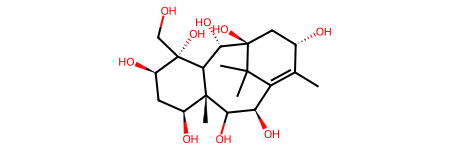

In [6]:
taxol = Chem.MolFromSmiles("CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@](C3[C@@H]([C@@](C2(C)C)(C[C@@H]1OC(=O)[C@@H]([C@H](C5=CC=CC=C5)NC(=O)C6=CC=CC=C6)O)O)OC(=O)C7=CC=CC=C7)(CO4)OC(=O)C)O)C)OC(=O)C")
formula, deconstruction = deconstruct2backbone(taxol)

#formula = final backbone with decorated oxygens
#deconstruction = the appended list of each action along the way for troubleshooting

print(CalcMolFormula(formula))
formula = Chem.MolFromSmiles(Chem.MolToSmiles(formula))
# produce image of deconstructed taxol
print(Chem.MolToSmiles(formula, allBondsExplicit=True))
formula

# Dictionary of Natural Products

## Import DNP dataset(s) and deconstruct

In [7]:
# Updated DNP (V30.2) library
deconstruction_mol = pd.read_csv("C:/Users/15099/Desktop/Diterpene_Submission_Material/Supplemental Data/Supp.1a.DNP_Diterpene_Mining_v30.2.csv", sep=",", encoding='utf-8')
deconstruction_mol = deconstruction_mol.dropna(subset= ["SMILES"],axis=0).reset_index(drop=True)

print("Shape of DNP Database before formatting:", np.shape(deconstruction_mol))
counter = 0
empty = []
#format some DNP Smiles for interpretation by RDKit
for i in deconstruction_mol["SMILES"]:
    counter = counter+1
    i = re.findall("\S+", i)[0]
    i = re.split("\.",i)[0]
    i = re.sub("C=\[N\]\(C\)c","C=[N+](C)c",i)
    i = re.sub("\(\[#6\]\)\(\[N\]#\[C-\]\)","([#6])([N+]#[C-])",i)
    empty.append(i)
deconstruction_mol["SMILES"] = empty

counter = 0

#convert SMILES to canonical form when possible
for i in deconstruction_mol["SMILES"]:
    if(str(Chem.CanonSmiles(i))!=str(i)):
        deconstruction_mol["SMILES"].iloc[counter]=str(Chem.CanonSmiles(i))        
    counter+=1
    
#some entries are missing "Molecular Formula" and "Molecular Weight", this calculates that
all_mol_formula = []
all_mol_weight = []
for i in deconstruction_mol["SMILES"]:
    all_mol_formula.append(CalcMolFormula(Chem.MolFromSmiles(i)))
    all_mol_weight.append(Descriptors.MolWt(Chem.MolFromSmiles(i)))
deconstruction_mol["Molecular_Formula"]=all_mol_formula
deconstruction_mol["Molecular_Weight"]=all_mol_weight

print("Shape of DNP Database after formatting:", np.shape(deconstruction_mol))
print("^^^ These should be the same... ^^^")
deconstruction_mol.head()

Shape of DNP Database before formatting: (25024, 12)


C:\Users\15099\AppData\Local\Temp\ipykernel_42960\3919093968.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deconstruction_mol["SMILES"].iloc[counter]=str(Chem.CanonSmiles(i))


Shape of DNP Database after formatting: (25024, 12)
^^^ These should be the same... ^^^


,Chemical_Name,Synonyms,Molecular_Formula,Molecular_Weight,SMILES,InChI,Type_of_Compound,Biological_Source,Smaller_Clade,Bigger_Clade,Use/Importance,Biological Use/Importance
0,"20(10→5)-Abeo-1(10),6,8,11,13-abietapentaene-1...",Prattinin A,C20H26O2,298.426,CC(C)c1cc2c(c(O)c1O)C1=CCCC(C)(C)C1(C)C=C2,InChIKey=RGZFDXJHQPJDER-UHFFFAOYNA-N,Miscellaneous abeoabietane diterpenoids,Constit. of Salvia prattii,Lamiaceae,Angiosperms (dicotyledons),NaN,NaN
1,"20(10→5)-Abeo-1(10),6,8,11,13-abietapentaene-1...",NaN,C20H26O3,314.425,CC(CO)c1cc2c(c(O)c1O)C1=CCCC(C)(C)C1(C)C=C2,InChIKey=ZVNOTTKXEKKEQE-UHFFFAOYSA-N,Miscellaneous abeoabietane diterpenoids,Constit. of Salvia apiana,Lamiaceae,Angiosperms (dicotyledons),NaN,NaN
2,"20(10→5)-Abeo-1(10),6,8,11,13-abietapentaene-1...",Plectranthol A,C27H30O6,450.531,CC(C)c1cc2c(c(O)c1O)C1=CCCC(C)(COC(=O)c3ccc(O)...,InChIKey=VIWAYXHMGDZRSR-UHFFFAOYSA-N,Miscellaneous abeoabietane diterpenoids,Constit. of leaves of Plectranthus nummularius,Lamiaceae,Angiosperms (dicotyledons),NaN,NaN
3,"19(4→3)-Abeo-3,8,11,13,15-abietapentaen-19,18-...",Nepetaefolin G,C20H22O2,294.394,C=C(C)c1ccc2c(c1)CCC1C3=C(CCC21C)C(=O)OC3,InChIKey=NTENWVGVVWIRJG-UHFFFAOYNA-N,19(4→3)-Abeoabietane diterpenoids,Constit. of Caryopteris nepetaefolia,Lamiaceae,Angiosperms (dicotyledons),NaN,NaN
4,"18(4→3)-Abeo-4(19),8,11,13-abietatetraene-12,1...",Triptobenzene P,C21H30O2,314.469,C=C1C(CO)CCC2(C)c3cc(OC)c(C(C)C)cc3CCC12,InChIKey=FOWPUUSGDVWLPM-UHFFFAOYSA-N,19(4→3)-Abeoabietane diterpenoids,Constit. of Tripterygium wilfordii,Celastraceae,Angiosperms (dicotyledons),NaN,NaN


In [10]:
#IF YOU WOULD LIKE TO SKIP TO A PROBLEM AREA
start=0
deconstruction_mol = deconstruction_mol.iloc[start:,]
index = start

#MAKE LIST OF COMPOUNDS THAT DO NOT FIT INTO A 20C BACKBONE CRITERIA
work2do = 1
work_list1 = []
length_comp = 0
carbon_number = []

#EMPTY LIST OF BACKBONES, SKELETONS, AND CARBON_NUMBER 
flattened_backbone = []
backbone = []

#LOOP THROUGH ALL SMILES IN DNP DATABASE AND CONVERT TO BACKBONE AND SKELETON
for i in deconstruction_mol["SMILES"]:
    diterpene = Chem.MolFromSmiles(i)
    formula, deconstruction = deconstruct2backbone(diterpene)
    Chemical_formula = CalcMolFormula(Chem.MolFromSmiles(Chem.MolToSmiles(formula)))
    match = re.search('C20', Chemical_formula)
    # Check if not C20, could be real, coulbe be an error
    if (match):
        if(len(deconstruction)>length_comp):
            length_comp = len(deconstruction)
            length_index = index
    else:
        #print(work2do,"\t",index, "\t", formula, "\t", Chemical_formula)
        work_list1.append(index)
        work2do = work2do+1
    # create list of Backbones (backbone), Skeletons (flattened_backbone), and the final number of carbons (carbon_number)
    backbone.append(Chem.MolToSmiles(formula))
    flattened_backbone.append(backbone_flattener(Chem.MolToSmiles(formula)))
    carbon_number.append(re.search("\d+", CalcMolFormula(formula))[0])

    # Print Progress
    if(index%1000==0):
        print(index, "finished thus far; \t", format(100*(index/len(list(deconstruction_mol["SMILES"]))), ".2f"), "% complete")
    
    index=index+1

0 finished thus far; 	 0.00 % complete
1000 finished thus far; 	 4.00 % complete


[12:24:16] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


2000 finished thus far; 	 7.99 % complete


[12:24:44] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:24:44] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:24:44] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:24:44] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


3000 finished thus far; 	 11.99 % complete
4000 finished thus far; 	 15.98 % complete


[12:25:13] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:25:16] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:25:21] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


5000 finished thus far; 	 19.98 % complete


[12:25:24] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


6000 finished thus far; 	 23.98 % complete
7000 finished thus far; 	 27.97 % complete
8000 finished thus far; 	 31.97 % complete


[12:26:18] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:26:20] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


9000 finished thus far; 	 35.97 % complete


[12:26:41] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:26:41] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:26:41] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:26:41] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:26:41] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:26:41] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:26:41] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:26:42] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:26:43] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:26:43] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


10000 finished thus far; 	 39.96 % complete


[12:26:51] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:26:57] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


11000 finished thus far; 	 43.96 % complete


[12:27:16] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:27:16] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:27:16] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


12000 finished thus far; 	 47.95 % complete
13000 finished thus far; 	 51.95 % complete
14000 finished thus far; 	 55.95 % complete
15000 finished thus far; 	 59.94 % complete


[12:28:21] non-ring atom 3 marked aromatic
[12:28:21] non-ring atom 3 marked aromatic


16000 finished thus far; 	 63.94 % complete
17000 finished thus far; 	 67.93 % complete
18000 finished thus far; 	 71.93 % complete


[12:29:09] Can't kekulize mol.  Unkekulized atoms: 14 15 17 18 20
[12:29:09] Can't kekulize mol.  Unkekulized atoms: 14 15 17 18 20
[12:29:14] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:29:14] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:29:14] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:29:14] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:29:15] Can't kekulize mol.  Unkekulized atoms: 6 9 10 11 12 13


19000 finished thus far; 	 75.93 % complete
20000 finished thus far; 	 79.92 % complete


[12:29:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9 12 17 22
[12:29:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9 12 17 22


21000 finished thus far; 	 83.92 % complete


[12:29:54] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


22000 finished thus far; 	 87.92 % complete
23000 finished thus far; 	 91.91 % complete
24000 finished thus far; 	 95.91 % complete


[12:31:04] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:31:04] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


25000 finished thus far; 	 99.90 % complete


In [11]:
# GENERATE SUPPLEMENTAL DATA 2A
# Add columns to Original DNP Dataset to include Backbone, Skeleton, and Carbon number
deconstruction_mol["Deconstructed Diterpene"]=backbone
deconstruction_mol["Sigma-Sigma Skeleton"]=flattened_backbone
deconstruction_mol["Carbon Number"]=carbon_number
deconstruction_mol.to_csv("Supp.2a.DNP_Diterpene_Mining_v30.2_Updated_Skeleton_Backbone.tsv", sep='\t', encoding='utf-8',index=False)
deconstruction_mol.head()

,Chemical_Name,Synonyms,Molecular_Formula,Molecular_Weight,SMILES,InChI,Type_of_Compound,Biological_Source,Smaller_Clade,Bigger_Clade,Use/Importance,Biological Use/Importance,Deconstructed Diterpene,Sigma-Sigma Skeleton,Carbon Number
0,"20(10→5)-Abeo-1(10),6,8,11,13-abietapentaene-1...",Prattinin A,C20H26O2,298.426,CC(C)c1cc2c(c(O)c1O)C1=CCCC(C)(C)C1(C)C=C2,InChIKey=RGZFDXJHQPJDER-UHFFFAOYNA-N,Miscellaneous abeoabietane diterpenoids,Constit. of Salvia prattii,Lamiaceae,Angiosperms (dicotyledons),NaN,NaN,CC(C)c1cc2c(c(O)c1O)C1=CCCC(C)(C)C1(C)C=C2,CC(C)C1CCC2C(CCC3(C)C2CCCC3(C)C)C1,20
1,"20(10→5)-Abeo-1(10),6,8,11,13-abietapentaene-1...",NaN,C20H26O3,314.425,CC(CO)c1cc2c(c(O)c1O)C1=CCCC(C)(C)C1(C)C=C2,InChIKey=ZVNOTTKXEKKEQE-UHFFFAOYSA-N,Miscellaneous abeoabietane diterpenoids,Constit. of Salvia apiana,Lamiaceae,Angiosperms (dicotyledons),NaN,NaN,CC(CO)c1cc2c(c(O)c1O)C1=CCCC(C)(C)C1(C)C=C2,CC(C)C1CCC2C(CCC3(C)C2CCCC3(C)C)C1,20
2,"20(10→5)-Abeo-1(10),6,8,11,13-abietapentaene-1...",Plectranthol A,C27H30O6,450.531,CC(C)c1cc2c(c(O)c1O)C1=CCCC(C)(COC(=O)c3ccc(O)...,InChIKey=VIWAYXHMGDZRSR-UHFFFAOYSA-N,Miscellaneous abeoabietane diterpenoids,Constit. of leaves of Plectranthus nummularius,Lamiaceae,Angiosperms (dicotyledons),NaN,NaN,CC(C)c1cc2c(c(O)c1O)C1=CCCC(C)(CO)C1(C)C=C2,CC(C)C1CCC2C(CCC3(C)C2CCCC3(C)C)C1,20
3,"19(4→3)-Abeo-3,8,11,13,15-abietapentaen-19,18-...",Nepetaefolin G,C20H22O2,294.394,C=C(C)c1ccc2c(c1)CCC1C3=C(CCC21C)C(=O)OC3,InChIKey=NTENWVGVVWIRJG-UHFFFAOYNA-N,19(4→3)-Abeoabietane diterpenoids,Constit. of Caryopteris nepetaefolia,Lamiaceae,Angiosperms (dicotyledons),NaN,NaN,C=C(C)c1ccc2c(c1)CCC1C(CO)=C(CO)CCC21C,CC(C)C1CCC2C(CCC3C(C)C(C)CCC23C)C1,20
4,"18(4→3)-Abeo-4(19),8,11,13-abietatetraene-12,1...",Triptobenzene P,C21H30O2,314.469,C=C1C(CO)CCC2(C)c3cc(OC)c(C(C)C)cc3CCC12,InChIKey=FOWPUUSGDVWLPM-UHFFFAOYSA-N,19(4→3)-Abeoabietane diterpenoids,Constit. of Tripterygium wilfordii,Celastraceae,Angiosperms (dicotyledons),NaN,NaN,C=C1C(CO)CCC2(C)c3cc(O)c(C(C)C)cc3CCC12,CC(C)C1CCC2C(CCC3C(C)C(C)CCC23C)C1,20


## Summarize diterpene skeleton data for later characterization

In [12]:
# GENERATE DNP DERIVED SKELETON DATA FOR SUPPLEMENTAL DATA 2E
DNP_Terpene_dataset_v2 = pd.read_csv("Supp.2a.DNP_Diterpene_Mining_v30.2_Updated_Skeleton_Backbone.tsv",sep="\t")
sample = pd.DataFrame()

# Column 1 for Frequency of compounds containing a specific skeleton
sample["frequency"] = np.unique(DNP_Terpene_dataset_v2["Sigma-Sigma Skeleton"], return_counts=True)[1]

# Column 2 for IUPAC name of Skeleton (if available) based on PubChem compound name
iupac = []
for i in np.unique(DNP_Terpene_dataset_v2["Sigma-Sigma Skeleton"], return_counts=True)[0]:
    smiles = i 
    compound = pcp.get_compounds(smiles, 'smiles')
    if compound:
        iupac_name = compound[0].iupac_name
        #print(f"IUPAC Name: {iupac_name}")
    else:
        iupac_name = "None"
        #print("None")
    iupac.append(iupac_name)
sample["IUPAC"] = iupac
    
# Column 3 for SMILEs of said Skeleton
sample["SMILES"] = np.unique(DNP_Terpene_dataset_v2["Sigma-Sigma Skeleton"], return_counts=True)[0]

test = []
for i in sample["SMILES"]:
    x = len(re.findall("C", i, re.IGNORECASE))
    test.append(x)

# Column 4 number of Carbons present in the skeleton (filtered later)
sample["Carbon Number"] = test

# Column 5 the index from the original v30.2 DNP dataset matching each skeleton
test = []
for i in np.unique(DNP_Terpene_dataset_v2["Sigma-Sigma Skeleton"]):
    x = 0
    index = []
    for j in DNP_Terpene_dataset_v2["Sigma-Sigma Skeleton"]:
        if i == j:
            index.append(x)  
        x = x+1
    test.append(index)
sample["index"] = test
sample = sample.sort_values(by = ['frequency'], ascending=False )
sample = sample.reset_index(drop=True)
print(sample.index)
print("Total Skeleton:", np.shape(sample))

# FILTERING STEPS
#These values used for pruning cases skeleton has more or less than 20C
#sample = sample.sort_values(by=['Carbon Number'])
# sample = sample.loc[sample['Carbon Number']>15]
# sample = sample.loc[sample['Carbon Number']<25]

# Keep skeletons with 20C structure, those that do not are likely mislabeled or not generated by terpene synthase activity
sample = sample.loc[sample['Carbon Number']==20]
sample = sample.reset_index(drop=True)
print("20C Skeleton:", np.shape(sample))
sample.head(10)
#sample = sample.loc[sample["frequency"]>1]

RangeIndex(start=0, stop=1230, step=1)
Total Skeleton: (1230, 5)
20C Skeleton: (671, 5)


,frequency,IUPAC,SMILES,Carbon Number,index
0,2510,"1,5,6,8a-tetramethyl-5-(3-methylpentyl)-1,2,3,...",CCC(C)CCC1(C)C(C)CCC2(C)C(C)CCCC12,20,"[1071, 1072, 1073, 1074, 1075, 1076, 1077, 107..."
1,2462,"2,5,5,8a-tetramethyl-1-(3-methylpentyl)-1,2,3,...",CCC(C)CCC1C(C)CCC2C(C)(C)CCCC12C,20,"[1023, 1024, 1158, 1159, 1160, 1161, 1162, 116..."
2,2052,"5,5,9,14-tetramethyltetracyclo[11.2.1.01,10.04...",CC1CC23CCC4C(C)(C)CCCC4(C)C2CCC1C3,20,"[1285, 1446, 1447, 1448, 1449, 1450, 1451, 145..."
3,1294,"4b,8,8-trimethyl-2-propan-2-yl-1,2,3,4,4a,5,6,...",CC(C)C1CCC2C(CCC3C(C)(C)CCCC23C)C1,20,"[503, 504, 505, 506, 507, 508, 509, 510, 511, ..."
4,1233,"1,7,11-trimethyl-4-propan-2-ylcyclotetradecane",CC1CCCC(C)CCC(C(C)C)CCC(C)CCC1,20,"[1233, 1234, 1772, 1773, 1774, 1775, 1776, 177..."
5,969,"2-ethyl-2,4b,8,8-tetramethyl-3,4,4a,5,6,7,8a,9...",CCC1(C)CCC2C(CCC3C(C)(C)CCCC23C)C1,20,"[522, 533, 1236, 1237, 1286, 1287, 1947, 1948,..."
6,697,"1,4a,8-trimethyl-11-propan-2-yl-2,3,4,5,6,7,8,...",CC1CCCC2(C)CCCC(C)C2CC(C(C)C)CC1,20,"[1979, 2853, 2854, 2855, 2856, 2857, 2858, 286..."
7,645,None,CCC1CCC2C(CCC3C(C)(C)CCCC23C)C1C,20,"[2117, 2118, 2119, 2120, 2121, 2122, 2123, 212..."
8,640,"2,6,10,14-tetramethylhexadecane",CCC(C)CCCC(C)CCCC(C)CCCC(C)C,20,"[995, 996, 997, 998, 1006, 1014, 1021, 1022, 1..."
9,539,"4,8,12,15,15-pentamethyltricyclo[9.3.1.03,8]pe...",CC1CCCC2(C)CCC3C(C)CCC(CC12)C3(C)C,20,"[1595, 6725, 9112, 9113, 9114, 9115, 9116, 911..."


In [13]:
sample.to_csv("Supp.2e.DNP_Diterpene_Skeleton_Summary.tsv", sep='\t', index=False)

# TeroKit

## Import TeroKit dataset(s) and deconstruct
### Diterpene, Triterpene, Sesquiterpene

In [14]:
# CHOOSE WHICH DATASET INTENDED TO ASSESS
TeroKit_mol = pd.read_csv("C:/Users/15099/Desktop/Diterpene_Submission_Material/Supplemental Data/Supp.1b.TeroKit_Diterpene_v2.0.tsv", sep="\t")
#TeroKit_mol = pd.read_csv("Supp.1c.TeroKit_Triterpene_v2.0.tsv", sep="\t")
#TeroKit_mol = pd.read_csv("Supp.1d.TeroKit_Sesquiterpene_v2.0.tsv", sep="\t")

TeroKit_mol = TeroKit_mol.rename(columns={'smiles': 'SMILES'})
TeroKit_mol.head()

,mol_id,formula,inchi,SMILES,category
0,TKC067344,C49H60O12Si,InChI=1S/C49H60O12Si/c1-29-36(57-30(2)50)27-49...,CC(=O)O[C@H]1C[C@@]2(O)[C@H](OC(=O)c3ccccc3)[C...,Diterpenoids
1,TKC000212,C20H32O,InChI=1S/C20H32O/c1-7-18(4)11-10-17-19(5)12-8-...,C=C[C@]1(C)CC[C@@H]2[C@@]3(C)CC[C@@H](C)C(=C)[...,Diterpenoids
2,TKC000228,C29H38O10,"InChI=1S/C29H38O10/c1-14-17(31)12-28(26(3,4)36...",CC(=O)OC12COC1CC(O)C1(C)C(O)C(O)C3=C(C)C(O)CC3...,Diterpenoids
3,TKC187034,C20H30O2,"InChI=1S/C20H30O2/c1-12-9-20-8-7-15-18(2,3)17(...",C=C1C[C@@]23CC[C@@H]4C(C)(C)[C@H](O)C(=O)C[C@@...,Diterpenoids
4,TKC186864,C28H40O9,InChI=1S/C28H40O9/c1-8-9-23(31)36-21-12-10-15(...,CCCC(=O)O[C@H]1CC/C(C)=C\[C@@H]2OC(=O)[C@H](C)...,Diterpenoids


In [15]:
# ensure correct formatting for deconstruction (i.e. formatting matches RDKit) 
index = 0
print("Shape of TeroKit Database before formatting:", np.shape(TeroKit_mol))
for i in TeroKit_mol['mol_id']:
    if(isinstance(i, float)):
        TeroKit_mol['mol_id'].iloc[index]="Unknown"
        TeroKit_mol['category'].iloc[index]=TeroKit_mol['SMILES'].iloc[index]
        TeroKit_mol['SMILES'].iloc[index]=TeroKit_mol['inchi'].iloc[index]
        TeroKit_mol['inchi'].iloc[index]=str(TeroKit_mol['formula'].iloc[index])
        TeroKit_mol['formula'].iloc[index]=CalcMolFormula(Chem.MolFromSmiles(TeroKit_mol['SMILES'].iloc[index]))
        #print(TeroKit_mol.iloc[index])
    index+=1
counter = 0
for i in TeroKit_mol["SMILES"]:
    if(str(Chem.CanonSmiles(i))!=str(i)):
        TeroKit_mol["SMILES"].iloc[counter]=str(Chem.CanonSmiles(i))
    counter+=1
print("Shape of TeroKit Database after formatting:", np.shape(TeroKit_mol))
print("^^^ These should be the same... ^^^")

Shape of TeroKit Database before formatting: (40833, 5)


[12:48:02] Conflicting single bond directions around double bond at index 1.
[12:48:02]   BondStereo set to STEREONONE and single bond directions set to NONE.
[12:48:02] Conflicting single bond directions around double bond at index 1.
[12:48:02]   BondStereo set to STEREONONE and single bond directions set to NONE.
[12:48:04] Conflicting single bond directions around double bond at index 5.
[12:48:04]   BondStereo set to STEREONONE and single bond directions set to NONE.
[12:48:04] Conflicting single bond directions around double bond at index 5.
[12:48:04]   BondStereo set to STEREONONE and single bond directions set to NONE.
[12:48:08] Conflicting single bond directions around double bond at index 5.
[12:48:08]   BondStereo set to STEREONONE and single bond directions set to NONE.
[12:48:08] Conflicting single bond directions around double bond at index 5.
[12:48:08]   BondStereo set to STEREONONE and single bond directions set to NONE.
[12:48:30] Conflicting single bond directions 

Shape of TeroKit Database after formatting: (40833, 5)
^^^ These should be the same... ^^^


In [16]:
#IF YOU WOULD LIKE TO SKIP TO A PROBLEM AREA
start=0
TeroKit_mol = TeroKit_mol.iloc[start:,]
index = start

#MAKE LIST OF COMPOUNDS THAT DO NOT FIT INTO A 20C BACKBONE CRITERIA
work2do = 1
work_list1 = []

#EMPTY LIST OF BACKBONES, SKELETONS, AND CARBON_NUMBER
flattened_backbone = []
backbone = []
carbon_number = []

#LOOP THROUGH ALL SMILES IN DNP DATABASE AND CONVERT TO BACKBONE AND SKELETON
for i in TeroKit_mol["SMILES"]:
    diterpene = Chem.MolFromSmiles(i)
    formula, deconstruction = deconstruct2backbone(diterpene)
    Chemical_formula = CalcMolFormula(Chem.MolFromSmiles(Chem.MolToSmiles(formula)))
    match = re.search('C20', Chemical_formula)
    # Check if not C20, could be real, coulbe be an error
    if(match):
        if(len(deconstruction)>length_comp):
            length_comp = len(deconstruction)
            length_index = index
    else:
        #print(work2do,"\t",index, "\t", formula, "\t", Chemical_formula)
        work_list1.append(index)
        work2do = work2do+1
    flattened_backbone.append(backbone_flattener(Chem.MolToSmiles(formula)))
    backbone.append(Chem.MolToSmiles(formula))
    carbon_number.append(re.search("\d+", CalcMolFormula(formula))[0])
    
    # Print Progress
    if(index%1000==0):
        print(index, "finished thus far; \t", format(100*(index/len(list(TeroKit_mol["SMILES"]))), ".2f"), "% complete")

    index=index+1

0 finished thus far; 	 0.00 % complete


[12:48:40] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:48:48] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:48:49] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:48:49] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:48:49] non-ring atom 3 marked aromatic
[12:48:49] non-ring atom 3 marked aromatic


1000 finished thus far; 	 2.45 % complete


[12:48:57] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 18 19
[12:48:57] Can't kekulize mol.  Unkekulized atoms: 4 6 8 9 10
[12:49:02] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:49:06] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


2000 finished thus far; 	 4.90 % complete


[12:49:14] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:49:15] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:49:17] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:49:19] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


3000 finished thus far; 	 7.35 % complete


[12:49:33] Can't kekulize mol.  Unkekulized atoms: 7 8 9 13 17 18 19 20 21 22 23 24 25 26
[12:49:33] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[12:49:47] Can't kekulize mol.  Unkekulized atoms: 7 8 9 13 17 18 19 20 21 22 23 24 25 26
[12:49:47] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18


4000 finished thus far; 	 9.80 % complete


[12:49:56] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:50:09] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


5000 finished thus far; 	 12.24 % complete


[12:50:24] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:50:24] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:50:26] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18


6000 finished thus far; 	 14.69 % complete


[12:50:39] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:50:51] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


7000 finished thus far; 	 17.14 % complete
8000 finished thus far; 	 19.59 % complete
9000 finished thus far; 	 22.04 % complete
10000 finished thus far; 	 24.49 % complete


[12:52:01] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


11000 finished thus far; 	 26.94 % complete


[12:52:16] Can't kekulize mol.  Unkekulized atoms: 4 6 7 8 10 12 13 14


12000 finished thus far; 	 29.39 % complete


[12:52:51] Can't kekulize mol.  Unkekulized atoms: 6 9 10 11 12 13


13000 finished thus far; 	 31.84 % complete
14000 finished thus far; 	 34.29 % complete
15000 finished thus far; 	 36.73 % complete


[12:53:50] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:53:50] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:53:50] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


16000 finished thus far; 	 39.18 % complete


[12:54:00] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:54:00] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:54:10] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


17000 finished thus far; 	 41.63 % complete


[12:54:25] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


18000 finished thus far; 	 44.08 % complete


[12:54:34] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:54:37] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:54:37] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:54:41] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


19000 finished thus far; 	 46.53 % complete
20000 finished thus far; 	 48.98 % complete
21000 finished thus far; 	 51.43 % complete


[12:55:39] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:55:51] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


22000 finished thus far; 	 53.88 % complete
23000 finished thus far; 	 56.33 % complete
24000 finished thus far; 	 58.78 % complete


[12:56:30] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:56:32] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:56:45] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:56:45] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:56:45] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:56:45] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


25000 finished thus far; 	 61.22 % complete


[12:56:50] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9 12 17 22
[12:57:09] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


26000 finished thus far; 	 63.67 % complete
27000 finished thus far; 	 66.12 % complete
28000 finished thus far; 	 68.57 % complete


[12:57:54] non-ring atom 3 marked aromatic
[12:57:54] non-ring atom 3 marked aromatic


29000 finished thus far; 	 71.02 % complete


[12:58:15] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:58:15] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


30000 finished thus far; 	 73.47 % complete


[12:58:24] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:58:33] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


31000 finished thus far; 	 75.92 % complete


[12:58:55] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


32000 finished thus far; 	 78.37 % complete
33000 finished thus far; 	 80.82 % complete


[12:59:34] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


34000 finished thus far; 	 83.27 % complete


[12:59:47] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:59:51] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:59:51] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[12:59:51] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


35000 finished thus far; 	 85.71 % complete


[13:00:15] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


36000 finished thus far; 	 88.16 % complete


[13:00:27] Can't kekulize mol.  Unkekulized atoms: 7 8 9 13 17 18 19 20 21 22 23 24 25 26
[13:00:27] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18


37000 finished thus far; 	 90.61 % complete


[13:00:56] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


38000 finished thus far; 	 93.06 % complete


[13:01:04] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[13:01:19] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[13:01:19] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[13:01:19] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)
[13:01:19] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


39000 finished thus far; 	 95.51 % complete


[13:01:37] stereo atoms in input cannot be mapped to output (atoms are no longer bonded)


40000 finished thus far; 	 97.96 % complete


In [17]:
# GENERATE TEROKIT DERIVED SUPPLEMENTAL DATA 2B, 2C, or 2D

# Add columns to Original DNP Dataset to include Backbone, Skeleton, and Carbon number
TeroKit_mol["Deconstructed Diterpene"]=backbone
TeroKit_mol["Sigma-Sigma Skeleton"]=flattened_backbone
TeroKit_mol["Carbon Number"]=carbon_number

'''NOTE: MAKE SURE TO SPECIFIY WHICH DATASET OUTPUT YOU WOULD LIKE TO REFERENCE HERE'''
TeroKit_mol.to_csv("Supp.2b.TeroKit_Diterpene_v2.0_Updated_Skeleton_Backbone.tsv", sep='\t', index=False)
#TeroKit_mol.to_csv("Supp.2c.TeroKit_Triterpene_v2.0_Updated_Skeleton_Backbone.tsv", sep='\t', index=False)
#TeroKit_mol.to_csv("Supp.2d.TeroKit_Sesquiterpene_v2.0_Updated_Skeleton_Backbone.tsv", sep='\t', index=False)

TeroKit_mol.head()

,mol_id,formula,inchi,SMILES,category,Deconstructed Diterpene,Sigma-Sigma Skeleton,Carbon Number
0,TKC067344,C49H60O12Si,InChI=1S/C49H60O12Si/c1-29-36(57-30(2)50)27-49...,CC(=O)O[C@H]1C[C@@]2(O)[C@H](OC(=O)c3ccccc3)[C...,Diterpenoids,CC1=C2[C@@H](O)[C@H](O)[C@@]3(C)[C@H]([C@@H](O...,CC1CCCC2(C)CCC3C(C)CCC(CC12)C3(C)C,20
1,TKC000212,C20H32O,InChI=1S/C20H32O/c1-7-18(4)11-10-17-19(5)12-8-...,C=C[C@]1(C)CC[C@@H]2[C@@]3(C)CC[C@@H](C)C(=C)[...,Diterpenoids,C=C[C@@](C)(O)CC[C@@H]1[C@@]2(C)CC[C@@H](C)C(=...,CCC(C)CCC1C(C)CCC2C(C)C(C)CCC12C,20
2,TKC000228,C29H38O10,"InChI=1S/C29H38O10/c1-14-17(31)12-28(26(3,4)36...",CC(=O)OC12COC1CC(O)C1(C)C(O)C(O)C3=C(C)C(O)CC3...,Diterpenoids,CC1=C2C(O)C(O)C3(C)C(O)CC(O)C(O)(CO)C3C(O)C2(C...,CC1CCCC2(C)CCC3C(C)CCC3(C(C)C)CC12,20
3,TKC187034,C20H30O2,"InChI=1S/C20H30O2/c1-12-9-20-8-7-15-18(2,3)17(...",C=C1C[C@@]23CC[C@@H]4C(C)(C)[C@H](O)C(=O)C[C@@...,Diterpenoids,C=C1C[C@@]23CC[C@@H]4C(C)(C)[C@H](O)C(O)C[C@@]...,CC1CC23CCC4C(C)(C)CCCC4(C)C2CCC1C3,20
4,TKC186864,C28H40O9,InChI=1S/C28H40O9/c1-8-9-23(31)36-21-12-10-15(...,CCCC(=O)O[C@H]1CC/C(C)=C\[C@@H]2OC(=O)[C@H](C)...,Diterpenoids,CC1=CC[C@H](O)[C@@]2(C)[C@H]1[C@@H](O)[C@@](O)...,CC1CCCC2(C)CCCC(C)C2CC(C(C)C)CC1,20


## Summarize diterpene skeleton data for later characterization

In [18]:
# GENERATE TEROKIT DERIVED SUPPLEMENTAL DATA 2F
Tero_Terpene_dataset_v2 = pd.read_csv("Supp.2b.TeroKit_Diterpene_v2.0_Updated_Skeleton_Backbone.tsv",sep="\t")

sample = pd.DataFrame()

# Column 1 for Frequency of compounds containing a specific skeleton
sample["frequency"] = np.unique(Tero_Terpene_dataset_v2["Sigma-Sigma Skeleton"], return_counts=True)[1]

# Column 2 for IUPAC name of Skeleton (if available) based on PubChem compound name
iupac = []
for i in np.unique(Tero_Terpene_dataset_v2["Sigma-Sigma Skeleton"], return_counts=True)[0]:
    smiles = i 
    compound = pcp.get_compounds(smiles, 'smiles')
    if compound:
        iupac_name = compound[0].iupac_name
        #print(f"IUPAC Name: {iupac_name}")
    else:
        iupac_name = "None"
        #print("None")
    iupac.append(iupac_name)

sample["IUPAC"] = iupac
    
# Column 3 for SMILEs of said Skeleton
sample["SMILES"] = np.unique(Tero_Terpene_dataset_v2["Sigma-Sigma Skeleton"], return_counts=True)[0]


# Column 4 number of Carbons present in the skeleton (filtered later)
test = []
for i in sample["SMILES"]:
    x = len(re.findall("C", i, re.IGNORECASE))
    test.append(x)
sample["Carbon Number"] = test


# Column 5 the index from the original v30.2 DNP dataset matching each skeleton
test = []
for i in np.unique(Tero_Terpene_dataset_v2["Sigma-Sigma Skeleton"]):
    x = 0
    index = []
    for j in Tero_Terpene_dataset_v2["Sigma-Sigma Skeleton"]:
        if i == j:
            index.append(x)  
        x = x+1
    test.append(index)
sample["index"] = test

sample = sample.sort_values(by = ['frequency'], ascending=False )
sample = sample.reset_index(drop=True)
print(sample.index)
print("Total Skeleton:", np.shape(sample))

# FILTERING STEPS
#These values used for pruning cases skeleton has more or less than 20C
#sample = sample.sort_values(by=['Carbon Number'])
# sample = sample.loc[sample['Carbon Number']>15]
# sample = sample.loc[sample['Carbon Number']<25]

# Keep skeletons with 20C structure, those that do not are likely mislabeled or not generated by terpene synthase activity
sample = sample.loc[sample['Carbon Number']==20]
sample = sample.reset_index(drop=True)
print("20C Skeleton:", np.shape(sample))
#sample = sample.loc[sample["frequency"]>1]

RangeIndex(start=0, stop=1716, step=1)
Total Skeleton: (1716, 5)
20C Skeleton: (872, 5)


In [19]:
sample.head(10)

,frequency,IUPAC,SMILES,Carbon Number,index
0,4060,"2,5,5,8a-tetramethyl-1-(3-methylpentyl)-1,2,3,...",CCC(C)CCC1C(C)CCC2C(C)(C)CCCC12C,20,"[5, 9, 17, 19, 22, 34, 36, 40, 73, 74, 115, 12..."
1,3372,"1,5,6,8a-tetramethyl-5-(3-methylpentyl)-1,2,3,...",CCC(C)CCC1(C)C(C)CCC2(C)C(C)CCCC12,20,"[8, 21, 38, 72, 77, 83, 93, 122, 125, 130, 131..."
2,3301,"5,5,9,14-tetramethyltetracyclo[11.2.1.01,10.04...",CC1CC23CCC4C(C)(C)CCCC4(C)C2CCC1C3,20,"[3, 23, 57, 69, 70, 71, 184, 188, 190, 217, 21..."
3,2050,"1,7,11-trimethyl-4-propan-2-ylcyclotetradecane",CC1CCCC(C)CCC(C(C)C)CCC(C)CCC1,20,"[29, 41, 64, 107, 113, 120, 152, 158, 159, 160..."
4,1854,"4b,8,8-trimethyl-2-propan-2-yl-1,2,3,4,4a,5,6,...",CC(C)C1CCC2C(CCC3C(C)(C)CCCC23C)C1,20,"[10, 32, 53, 76, 143, 168, 191, 198, 241, 277,..."
5,1350,"4,8,12,15,15-pentamethyltricyclo[9.3.1.03,8]pe...",CC1CCCC2(C)CCC3C(C)CCC(CC12)C3(C)C,20,"[0, 24, 26, 39, 82, 86, 87, 88, 89, 90, 102, 1..."
6,1228,"2-ethyl-2,4b,8,8-tetramethyl-3,4,4a,5,6,7,8a,9...",CCC1(C)CCC2C(CCC3C(C)(C)CCCC23C)C1,20,"[45, 48, 49, 62, 65, 79, 80, 95, 167, 172, 220..."
7,1173,"1,4a,8-trimethyl-11-propan-2-yl-2,3,4,5,6,7,8,...",CC1CCCC2(C)CCCC(C)C2CC(C(C)C)CC1,20,"[4, 15, 37, 68, 91, 146, 161, 163, 203, 205, 2..."
8,858,"2,6,10,14-tetramethylhexadecane",CCC(C)CCCC(C)CCCC(C)CCCC(C)C,20,"[25, 28, 47, 61, 66, 84, 101, 132, 245, 248, 2..."
9,844,None,CCC1CCC2C(CCC3C(C)(C)CCCC23C)C1C,20,"[33, 51, 59, 121, 129, 144, 147, 329, 375, 419..."


In [20]:
sample.to_csv("Supp.2f.Terokit_Diterpene_Skeleton_Summary.tsv", sep='\t', index=False)

## Graphical representation of diterpene skeleton abundance distribution

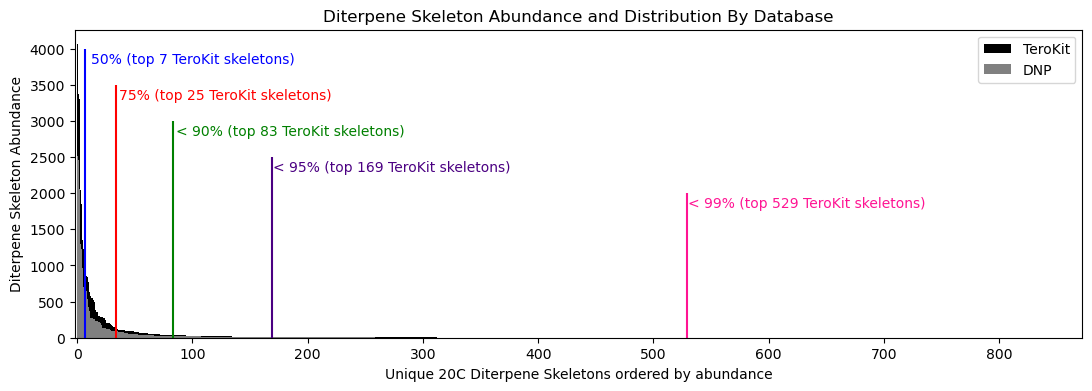

In [234]:
# Graphic Representation of Backbone abundance vs distribution
TeroKit_diterpene_summary = pd.read_csv("Supp.2f.Terokit_Diterpene_Skeleton_Summary.tsv", sep='\t')
DNP_diterpene_summary = pd.read_csv("Supp.2e.DNP_Diterpene_Skeleton_Summary.tsv", sep="\t")

plt.figure(figsize=(13,4))
plt.bar(TeroKit_diterpene_summary.index, TeroKit_diterpene_summary["frequency"], align="center", color="black", width=1,label="TeroKit")
plt.bar(DNP_diterpene_summary.index, DNP_diterpene_summary["frequency"],align="center", color="grey", width=1, label="DNP")
plt.legend()

plt.vlines(7,0,4000, linewidth=1.5, color="blue"); plt.text(12,3800,"50% (top 7 TeroKit skeletons)", color = "blue")
plt.vlines(34,0,3500, linewidth=1.5, color="red"); plt.text(36,3300,"75% (top 25 TeroKit skeletons)", color = "red")
plt.vlines(83,0,3000, linewidth=1.5, color="green"); plt.text(86,2800,"< 90% (top 83 TeroKit skeletons)", color = "green")
plt.vlines(169,0,2500, linewidth=1.5, color="indigo"); plt.text(170,2300,"< 95% (top 169 TeroKit skeletons)", color = "indigo")
plt.vlines(529,0,2000, linewidth=1.5, color="deeppink"); plt.text(530,1800,"< 99% (top 529 TeroKit skeletons)", color = "deeppink")

plt.xlim(-2,872)
plt.xlabel("Unique 20C Diterpene Skeletons ordered by abundance")
plt.ylabel("Diterpene Skeleton Abundance")
plt.title("Diterpene Skeleton Abundance and Distribution By Database")
plt.savefig("Supp.2g.Diterpene_Skeleton_Abundance_Distribution.png",dpi=600,bbox_inches='tight')
plt.show()

## Graphical representation of diterpene deconstruction based on Carbon Number

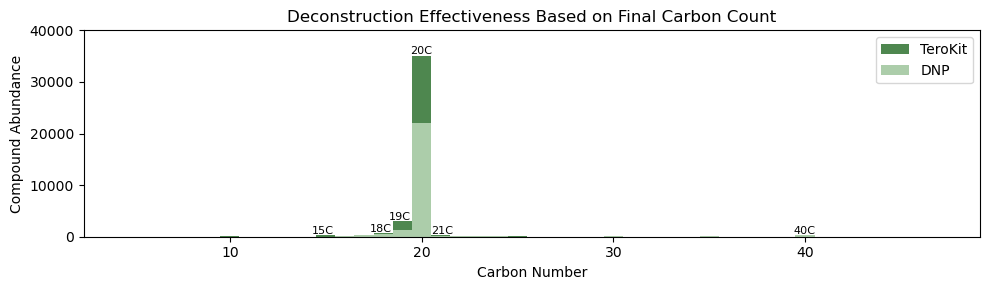

In [236]:
# Graphic Representation of Compound abundance vs carbon number
TeroKit_diterpene_updated = pd.read_csv("Supp.2b.TeroKit_Diterpene_v2.0_Updated_Skeleton_Backbone.tsv", sep="\t")
DNP_diterpene_updated = pd.read_csv("Supp.2a.DNP_Diterpene_Mining_v30.2_Updated_Skeleton_Backbone.tsv", sep="\t")

Carbon_deconstruction = list(TeroKit_diterpene_updated["Carbon Number"])
Carbon_deconstruction2= list(DNP_diterpene_updated["Carbon Number"])

plt.hist(Carbon_deconstruction, bins=np.unique(Carbon_deconstruction), color="#4e874f", align="left", label="TeroKit")
plt.hist(Carbon_deconstruction2,bins=np.unique(Carbon_deconstruction), color="#accdaa",align="left", label="DNP")
plt.legend()

plt.gcf().set_size_inches(10, 3)
plt.ylim(0,40000)
plt.text(19.4,35500,"20C", color = "black", fontsize=8)
plt.text(18.3,3200,"19C", color = "black", fontsize=8)
plt.text(17.3,950,"18C", color = "black", fontsize=8)
plt.text(20.5,550,"21C", color = "black", fontsize=8)
plt.text(14.3,500,"15C", color = "black", fontsize=8)
plt.text(39.4,500,"40C", color = "black", fontsize=8)

plt.xlabel("Carbon Number")
plt.ylabel("Compound Abundance")
plt.title("Deconstruction Effectiveness Based on Final Carbon Count")
plt.tight_layout()
plt.savefig("Supp.2h.Diterpene_Deconstructed_Skeleton_Carbon_Distribution.png",dpi=600,bbox_inches='tight')
plt.show()

In [23]:
print("C Number|","Reported Compounds\n-----------------------------------")
for i in range(len(np.unique(TeroKit_diterpene_updated["Carbon Number"]))):
    print(np.unique(TeroKit_diterpene_updated["Carbon Number"],return_counts=True)[0][i], "\t|",np.unique(TeroKit_diterpene_updated["Carbon Number"], return_counts=True)[1][i])

C Number| Reported Compounds
-----------------------------------
5 	| 1
6 	| 1
7 	| 1
8 	| 3
9 	| 12
10 	| 62
11 	| 26
12 	| 26
13 	| 19
14 	| 41
15 	| 323
16 	| 162
17 	| 316
18 	| 691
19 	| 2960
20 	| 35034
21 	| 312
22 	| 82
23 	| 51
24 	| 42
25 	| 47
26 	| 36
27 	| 32
28 	| 13
29 	| 16
30 	| 73
31 	| 10
32 	| 24
33 	| 5
34 	| 5
35 	| 16
36 	| 19
37 	| 6
38 	| 7
39 	| 21
40 	| 326
41 	| 4
42 	| 1
44 	| 2
50 	| 5


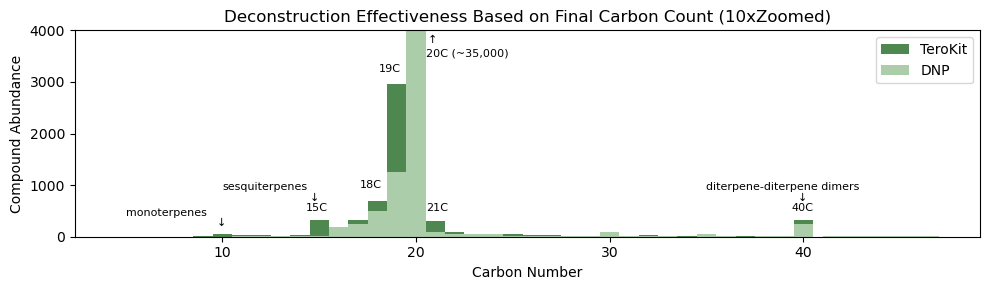

In [238]:
#Zoom into outliers and non-20-Carbon compounds
plt.hist(Carbon_deconstruction, bins=np.unique(Carbon_deconstruction), color="#4e874f", align="left", label="TeroKit")
plt.hist(Carbon_deconstruction2,bins=np.unique(Carbon_deconstruction), color="#accdaa",align="left", label="DNP")
plt.legend()

plt.gcf().set_size_inches(10, 3)
plt.ylim(0,4000)
plt.text(18.1,3200,"19C", color = "black", fontsize=8)
plt.text(17.1,950,"18C", color = "black", fontsize=8)
plt.text(20.5,500,"21C", color = "black", fontsize=8)


plt.text(14.3,500,"15C", color = "black", fontsize=8)
plt.text(14.5,700,"↓", color = "black", fontsize=8)
plt.text(10,900,"sesquiterpenes", color = "black", fontsize=8)

plt.text(39.4,500,"40C", color = "black", fontsize=8)
plt.text(39.7,700,"↓", color = "black", fontsize=8)
plt.text(35,900,"diterpene-diterpene dimers", color = "black", fontsize=8)

plt.text(9.7,200,"↓", color = "black", fontsize=8)
plt.text(5,400,"monoterpenes", color = "black", fontsize=8)

plt.text(20.5,3500,"20C (~35,000)", color = "black", fontsize=8)
plt.text(20.6,3750,"↑", color = "black", fontsize=8)


plt.xlabel("Carbon Number")
plt.ylabel("Compound Abundance")
plt.title("Deconstruction Effectiveness Based on Final Carbon Count (10xZoomed)")
plt.tight_layout()
plt.savefig("Supp.2i.10X_Zoomed_Diterpene_Deconstructed_Skeleton_Carbon_Distribution.png",dpi=600,bbox_inches='tight')


plt.show()

In [25]:
print("Total unique Skeletons reported in each dataset individually and combined\n")
skeleton1 = pd.read_csv("Supp.2e.DNP_Diterpene_Skeleton_Summary.tsv", sep="\t")
skeleton2 = pd.read_csv("Supp.2f.Terokit_Diterpene_Skeleton_Summary.tsv", sep="\t")
print("DNP:\t\t   ",len(np.unique(list(skeleton1["SMILES"]))))
print("Tero:\t\t   ",len(np.unique(list(skeleton2["SMILES"]))))
print("--------------------------------------------")
print("Total Unique:\t   ",len(np.unique(list(skeleton1["SMILES"])+list(skeleton2["SMILES"]))))

DNP_Skeleton = set(skeleton1["SMILES"])
TeroKit_Skeleton = set(skeleton2["SMILES"])

# Find the unique elements in each set
unique_to_DNP = DNP_Skeleton - TeroKit_Skeleton  # Items in list1 but not in list2
unique_to_Tero = TeroKit_Skeleton - DNP_Skeleton  # Items in list2 but not in list1

print("\n--------------------------------------------")
print("Unique to DNP:\t   ",len(unique_to_DNP))
print("Unique to TeroKit: ",len(unique_to_Tero))

Total unique Skeletons reported in each dataset individually and combined

DNP:		    671
Tero:		    872
--------------------------------------------
Total Unique:	    924

--------------------------------------------
Unique to DNP:	    52
Unique to TeroKit:  253


In [26]:
print("Number of Compounds represented by just the 20C Skeletons\n-----------------------------------------")
print("Ratio of 20C Skeletons in DNP vs All:\t ", sum(list(skeleton1['frequency']))/len(DNP_Terpene_dataset_v2["Sigma-Sigma Skeleton"]))
print("Ratio of 20C Skeletons in TeroKit vs All:", sum(list(skeleton2["frequency"]))/len(Tero_Terpene_dataset_v2["Sigma-Sigma Skeleton"]))

Number of Compounds represented by just the 20C Skeletons
-----------------------------------------
Ratio of 20C Skeletons in DNP vs All:	  0.87971547314578
Ratio of 20C Skeletons in TeroKit vs All: 0.8579825141429726


In [27]:
print("Total Nonfiltered Skeletons\n-----------------------------------------")
print("Tero:\t",len(np.unique(Tero_Terpene_dataset_v2["Sigma-Sigma Skeleton"])))

Total Nonfiltered Skeletons
-----------------------------------------
Tero:	 1716


In [28]:
print("Total Nonfiltered Skeletons\n-----------------------------------------")
print("DNP:\t",len(np.unique(DNP_Terpene_dataset_v2["Sigma-Sigma Skeleton"])))

Total Nonfiltered Skeletons
-----------------------------------------
DNP:	 1230


In [29]:
# Check Database for Duplicate entries based on canonical SMILE
TeroKit_all_canonical = []
for i in Tero_Terpene_dataset_v2["SMILES"]:
    temp_mol = Chem.MolFromSmiles(i)
    TeroKit_all_canonical.append(Chem.MolToSmiles(temp_mol))
    
print("TeroKit Redundancy Based on Canonical SMILEs entries:\n---------------------------------")
print("Total:\t      ",len(TeroKit_all_canonical))
print("Non-Redundant:",len(np.unique(TeroKit_all_canonical)))
print("Redundancy:   ",len(TeroKit_all_canonical)-len(np.unique(TeroKit_all_canonical)))
print("\nPercentage:   ",round((100*(len(TeroKit_all_canonical)-len(np.unique(TeroKit_all_canonical)))/len(TeroKit_all_canonical)),2),"%")

TeroKit Redundancy Based on Canonical SMILEs entries:
---------------------------------
Total:	       40833
Non-Redundant: 40759
Redundancy:    74

Percentage:    0.18 %


In [30]:
# Check Database for Duplicate entries based on canonical SMILE
DNP_all_canonical = []
for i in DNP_Terpene_dataset_v2["SMILES"]:
    temp_mol = Chem.MolFromSmiles(i)
    DNP_all_canonical.append(Chem.MolToSmiles(temp_mol))
    
print("DNP Redundancy Based on Canonical SMILEs entries:\n---------------------------------")
print("Total:\t      ",len(DNP_all_canonical))
print("Non-Redundant:",len(np.unique(DNP_all_canonical)))
print("Redundancy:   ",len(DNP_all_canonical)-len(np.unique(DNP_all_canonical)))
print("\nPercentage:   ",round((100*(len(DNP_all_canonical)-len(np.unique(DNP_all_canonical)))/len(DNP_all_canonical)),2),"%")

DNP Redundancy Based on Canonical SMILEs entries:
---------------------------------
Total:	       25024
Non-Redundant: 20014
Redundancy:    5010

Percentage:    20.02 %


In [31]:
# Remove Stereochemistry from TeroKit Compounds for comparision
print("Beginning TeroKit Flattening")
Flattened_Base_Tero = []
for i in Tero_Terpene_dataset_v2["SMILES"]:
    temp_mol = Chem.MolFromSmiles(i)
    for atom in temp_mol.GetAtoms():
        atom.SetChiralTag(Chem.ChiralType.CHI_UNSPECIFIED)
    for bond in temp_mol.GetBonds():
        bond.SetStereo(Chem.BondStereo.STEREONONE)
    temp_mol = Chem.MolToSmiles(temp_mol)
    Flattened_Base_Tero.append(temp_mol)
print("Finished Flattening TeroKit; Beginning DNP Flattening")
# Remove Stereochemistry from DNP Compounds for comparision
Flattened_Base_DNP = []
for i in DNP_Terpene_dataset_v2["SMILES"]:
    temp_mol = Chem.MolFromSmiles(i)
    for atom in temp_mol.GetAtoms():
        atom.SetChiralTag(Chem.ChiralType.CHI_UNSPECIFIED)
    for bond in temp_mol.GetBonds():
        bond.SetStereo(Chem.BondStereo.STEREONONE)
    temp_mol = Chem.MolToSmiles(temp_mol)
    Flattened_Base_DNP.append(temp_mol)
print("Finished")

# Sanity and QC Check
print("Original Tero:  ", len(Tero_Terpene_dataset_v2["SMILES"]))
print("Flattened Tero: ", len(np.unique(Flattened_Base_Tero)))

print("\nOriginal DNP:   ", len(DNP_Terpene_dataset_v2["SMILES"]))
print("Flattened DNP:  ", len(np.unique(Flattened_Base_DNP)))
print("Numbers should be smaller, since chirality and any duplicates are being removed")

Beginning TeroKit Flattening
Finished Flattening TeroKit; Beginning DNP Flattening
Finished
Original Tero:   40833
Flattened Tero:  26057

Original DNP:    25024
Flattened DNP:   19928
Numbers should be smaller, since chirality and any duplicates are being removed


In [32]:
# Database Uniqueness
DNP_Skeleton = set(Flattened_Base_DNP)
TeroKit_Skeleton = set(Flattened_Base_Tero)

# Find the unique elements in each set
unique_to_DNP = DNP_Skeleton - TeroKit_Skeleton  # Items in list1 but not in list2
unique_to_Tero = TeroKit_Skeleton - DNP_Skeleton  

print("Percentage of compounds unique to the DNP Database")
print("Unique:",len(unique_to_DNP))
print("Total:",len(DNP_Skeleton),"\n--------------",)
print(round(100*(len(unique_to_DNP)/len(DNP_Skeleton)),2),"%")

print("\n\nPercentage of compounds unique to the TeroKit Database")
print("Unique:",len(unique_to_Tero))
print("Total:",len(TeroKit_Skeleton),"\n--------------",)
print(round(100*(len(unique_to_Tero)/len(TeroKit_Skeleton)),2),"%")

Percentage of compounds unique to the DNP Database
Unique: 3354
Total: 19928 
--------------
16.83 %


Percentage of compounds unique to the TeroKit Database
Unique: 9483
Total: 26057 
--------------
36.39 %


In [140]:
# GENERATE SUPPLEMENTAL DATA FILE SUPP.2J
# This block prepares data for visualizing all skeleton structures in a PDF
DNP_Skeleton = pd.read_csv("Supp.2e.DNP_Diterpene_Skeleton_Summary.tsv", sep="\t")
TeroKit_Skeleton = pd.read_csv("Supp.2f.Terokit_Diterpene_Skeleton_Summary.tsv", sep="\t")

All_Skeleton_df = pd.DataFrame({'Average': [],'DNP Abundance': [],
                                'TeroKit Abundance': [], 'SMILES':[], 
                                "IUPAC":[], "Present in DNP":[], 
                                "Present in TeroKit":[]} )

All_Skeletons = np.unique(list(DNP_Skeleton["SMILES"])+list(TeroKit_Skeleton["SMILES"])) 
#print("Total\t DNP\t Tero\t SMILE\tIUPAC\t")
in_DNP = "Absent"; in_TeroKit="Absent"
for i in All_Skeletons:
    
    #calc occurances in DNP
    if(i in list(DNP_Skeleton["SMILES"])):
        DNP_count = int(DNP_Skeleton["frequency"][DNP_Skeleton["SMILES"]==i])
        IUPAC_name = str(DNP_Skeleton["IUPAC"][DNP_Skeleton["SMILES"]==i].iloc[0])
        in_DNP = "Present"
    else:DNP_count = 0; in_DNP="Absent"
        
    #calc occurances in TeroKit
    if(i in list(TeroKit_Skeleton["SMILES"])):
        Tero_count = int(TeroKit_Skeleton["frequency"][TeroKit_Skeleton["SMILES"]==i])    
        IUPAC_name = str(TeroKit_Skeleton["IUPAC"][TeroKit_Skeleton["SMILES"]==i].iloc[0])
        in_TeroKit = "Present"
    else: Tero_count = 0; in_TeroKit = "Absent"
    
    if(IUPAC_name=="nan"):
        IUPAC_name="Unknown"
        
    total=int(DNP_count+Tero_count)/2
    new_row = pd.DataFrame({'Average': [total],'DNP Abundance': [DNP_count],
                            'TeroKit Abundance': [Tero_count], 'SMILES':[i],
                            "IUPAC":[IUPAC_name],"Present in DNP":[in_DNP], 
                            "Present in TeroKit":[in_TeroKit]})
    All_Skeleton_df = pd.concat([All_Skeleton_df, new_row], ignore_index=True)
    #print(total,"\t",DNP_count,"\t",Tero_count,"\t",i,"\t",IUPAC_name)

All_Skeleton_df = All_Skeleton_df.sort_values(by='Average', ascending=False)
All_Skeleton_df.reset_index(drop=True, inplace=True)
All_Skeleton_df.head(10)

,Average,DNP Abundance,TeroKit Abundance,SMILES,IUPAC,Present in DNP,Present in TeroKit
0,3261.0,2462.0,4060.0,CCC(C)CCC1C(C)CCC2C(C)(C)CCCC12C,"2,5,5,8a-tetramethyl-1-(3-methylpentyl)-1,2,3,...",Present,Present
1,2941.0,2510.0,3372.0,CCC(C)CCC1(C)C(C)CCC2(C)C(C)CCCC12,"1,5,6,8a-tetramethyl-5-(3-methylpentyl)-1,2,3,...",Present,Present
2,2676.5,2052.0,3301.0,CC1CC23CCC4C(C)(C)CCCC4(C)C2CCC1C3,"5,5,9,14-tetramethyltetracyclo[11.2.1.01,10.04...",Present,Present
3,1641.5,1233.0,2050.0,CC1CCCC(C)CCC(C(C)C)CCC(C)CCC1,"1,7,11-trimethyl-4-propan-2-ylcyclotetradecane",Present,Present
4,1574.0,1294.0,1854.0,CC(C)C1CCC2C(CCC3C(C)(C)CCCC23C)C1,"4b,8,8-trimethyl-2-propan-2-yl-1,2,3,4,4a,5,6,...",Present,Present
...,...,...,...,...,...,...,...
919,0.5,0.0,1.0,CC1CCCCC1C(C1CCCCC1)C1CCCCC1,Unknown,Absent,Present
920,0.5,0.0,1.0,CC1CCCCC(C)CCC(C(C)C)CCC(C)CC1,Unknown,Absent,Present
921,0.5,0.0,1.0,CC1CCCC2C(CCC3(C)C(C)(C)CCCC23C)C1,Unknown,Absent,Present
922,0.5,0.0,1.0,CC1CCCC2(C)CCC3CC1CCC2(C)CC3(C)C,Unknown,Absent,Present


In [242]:
# THIS BLOCK OF CODE WAS HELPED IN PART BY CHATGPT
# This Block outputs a PDF containing all Unique Skeletons represented in the DNP and TeroKit Databases

# Create a directory for SMILE images
if os.path.exists("temp_images/"):x=0
else: os.mkdir("temp_images") 

# Generate a PDF
output_pdf = "Supp.2j.Skeleton_Visual_With_TeroKit_DNP_Abundances.pdf"
c = canvas.Canvas(output_pdf, pagesize=letter)

# Add a title at the top of the first page
title = "Indexed DNP & TeroKit Skeletons Abundance"
c.setFontSize(16)  # Set a larger, bold font for the title
c.drawCentredString(page_width / 2, page_height - 1 * inch, title) 

# Set Parameters for all entries
c.setFontSize(9)
page_width, page_height = letter

# Layout settings
left_margin = 1 * inch
top_margin = 1 * inch
bottom_margin = 1 * inch
spacing = 0.25 * inch
img_size = 1 * inch
columns = 5  # Number of images per row
column_width = (page_width - 2 * left_margin) / columns

# Starting positions
current_x = left_margin
current_y = page_height - top_margin
row_height = img_size +  2 * spacing #+ spacing  # Height for each row

# Helper function to start a new page
def start_new_page():
    global current_x, current_y
    c.showPage()  # End current page
    c.setFontSize(9)
    current_x = left_margin
    current_y = page_height - top_margin

# Iterate through the dataframe
for index, row in All_Skeleton_df.iterrows():
    smiles = row["SMILES"]
    name = int(row["TeroKit Abundance"])
    prop = int(row["DNP Abundance"])
    
    
    # Generate RDKit Molecule from SMILES
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        # Create the image
        img = Draw.MolToImage(mol, size=(200, 200))
        img_path = f"temp_images/temp_image_{index}.png"
        img.save(img_path)
        
        # Draw the image
        c.drawImage(img_path, current_x, current_y - img_size, width=img_size, height=img_size)
        
        # Draw the details
        text_y = current_y - img_size - spacing
        c.drawString(current_x, text_y+18, f"Index {index}")
        c.drawString(current_x, text_y+18-spacing*0.5, f"DNP Count: {name}")
        c.drawString(current_x, text_y+18-spacing, f"TeroKit Count: {prop}")
        
        # Move to the next column
        current_x += column_width

        # Check if we've reached the end of the row
        if current_x + column_width > page_width - left_margin:
            # Start a new row
            current_x = left_margin
            current_y -= row_height

        # Check if we've reached the end of the page
        if current_y - row_height < bottom_margin:
            start_new_page()
    else:
        print(f"Invalid SMILES: {smiles}")

# Save the PDF
c.save()

print(f"PDF saved as {output_pdf}")


PDF saved as Supp.2j.Skeleton_Visual_With_TeroKit_DNP_Abundances.pdf


In [247]:
# SUBSET COMPOUNDS THAT CONTAIN COMPONENTS THAT ARE NOT JUST C,H,O
Tero_Terpene_dataset_v2['formula']

allowed_pattern = r'^[CHO0-9]*$'  # Only alphanumeric characters
non_O_decoration = Tero_Terpene_dataset_v2['formula'].str.fullmatch(allowed_pattern)
Tero_Terpene_dataset_v2[~non_O_decoration]

,mol_id,formula,inchi,SMILES,category,Deconstructed Diterpene,Sigma-Sigma Skeleton,Carbon Number
0,TKC067344,C49H60O12Si,InChI=1S/C49H60O12Si/c1-29-36(57-30(2)50)27-49...,CC(=O)O[C@H]1C[C@@]2(O)[C@H](OC(=O)c3ccccc3)[C...,Diterpenoids,CC1=C2[C@@H](O)[C@H](O)[C@@]3(C)[C@H]([C@@H](O...,CC1CCCC2(C)CCC3C(C)CCC(CC12)C3(C)C,20
25,Unknown,C43H73O6P,InChI=1S/C43H73O6P/c1-35(2)17-11-19-37(5)21-13...,CC(C)=CCC/C(C)=C/CC/C(C)=C/CC/C(C)=C/COC[C@@H]...,Diterpenoids,CC(C)=CCC/C(C)=C/CC/C(C)=C/CC/C(C)=C/CO,CCC(C)CCCC(C)CCCC(C)CCCC(C)C,20
26,TKC067955,C49H53NO15,InChI=1S/C49H53NO15/c1-26-33(63-45(58)39(62-28...,CC(=O)O[C@H]1C(=O)[C@@]2(C)[C@H]([C@@H](OC(=O)...,Diterpenoids,CC1=C2[C@@H](O)C(O)[C@@]3(C)[C@H]([C@@H](O)[C@...,CC1CCCC2(C)CCC3C(C)CCC(CC12)C3(C)C,20
28,Unknown,C55H65N4O6-,InChI=1S/C55H66N4O6/c1-12-38-35(8)42-27-43-36(...,C=Cc1c(C)c2[n-]c1=CC1=NC(=C(CC)C1=CO)C=C1N=C3C...,Diterpenoids,CC(C)=CCC/C(C)=C/CC/C(C)=C/CC/C(C)=C/CO,CCC(C)CCCC(C)CCCC(C)CCCC(C)C,20
30,TKC173168,C23H37NO6,InChI=1S/C23H37NO6/c1-5-24-11-20(25)7-6-17(29-...,CCN1C[C@]2(O)CC[C@H](OC)[C@@]34[C@@H]2C[C@H]([...,Diterpenoids,C[C@]1(O)CC[C@H](O)[C@]23C[C@@H](C[C@@H]21)[C@...,CC1CCCC23CC(CC12)C1CCC2CC1C3C2,18
...,...,...,...,...,...,...,...,...
40782,TKC207429,C21H35BrO3,InChI=1S/C21H35BrO3/c1-14-7-8-16(22)20(6)12-9-...,C=C1CC[C@H](Br)[C@@]2(C)CC[C@H](C(C)(C)/C=C/[C...,Diterpenoids,C=C1CC[C@H](O)[C@@]2(C)CC[C@H](C(C)(C)/C=C/[C@...,CC(C)CCCC(C)(C)C1CCC2(C)CCCC(C)C2C1,21
40783,TKC207445,C20H29BrO5,"InChI=1S/C20H29BrO5/c1-18(2,24)7-4-5-12-10-26-...",CC(C)(O)/C=C/C=C1/COC(=O)[C@@H]2[C@@H]1CC[C@@]...,Diterpenoids,CC(C)(O)/C=C/C=C(/CO)[C@H]1CC[C@@]2(C)C[C@](O)...,CC(C)CCCC(C)C1CCC2(C)CCCC(C2)C1C,20
40788,TKC207664,C23H35NO5,InChI=1S/C23H35NO5/c1-4-24-10-22(11-27-2)6-5-1...,CCN1C[C@]2(COC)CC[C@H](OC)C34C1OC(C=C1C[C@H](O...,Diterpenoids,C[C@]1(CO)CC[C@H](O)C2(CO)C1C(O)C=C1C[C@H](O)C...,CC1(C)CCCC2(C)C3CC4CCC(CCC12)C3C4,19
40805,Unknown,C42H55NO15,InChI=1S/C42H55NO15/c1-21(2)37(49)55-32-24(6)3...,C=C1[C@H](OC(=O)C(C)C)[C@@H](OC(C)=O)[C@@H](OC...,Diterpenoids,C=C1[C@H](O)[C@@H](O)[C@@H](O)C(C)(C)/C=C\[C@H...,CC1CCCC(C)(C)CCC(C)CC2CC(C)CC2C1,20


In [252]:
#Subset DNP Compounds that are not just C,H,O
DNP_Terpene_dataset_v2['Molecular_Formula']

allowed_pattern = r'^[CHO0-9]*$'  # Only alphanumeric characters
non_O_decoration = DNP_Terpene_dataset_v2['Molecular_Formula'].str.fullmatch(allowed_pattern)
DNP_Terpene_dataset_v2[~non_O_decoration]

,Chemical_Name,Synonyms,Molecular_Formula,Molecular_Weight,SMILES,InChI,Type_of_Compound,Biological_Source,Smaller_Clade,Bigger_Clade,Use/Importance,Biological Use/Importance,Deconstructed Diterpene,Sigma-Sigma Skeleton,Carbon Number
16,"11(15→1)-Abeo-20-chloro-11-taxene-2,4,5,7,9,10...",Taxuchin B,C31H41ClO11,625.111,CC(=O)OC1CC(O)C(O)(CCl)C2C(OC(C)=O)C3(C(C)(C)O...,InChIKey=TUUVBJSOQMAIBP-UHFFFAOYSA-N,11(15→1)-Abeotaxane diterpenoids,Constit. of Taxus chinensis,Taxaceae,Gymnosperms,NaN,NaN,CC1=C2C(O)C(O)C3(C)C(O)CC(O)C(O)(CO)C3C(O)C2(C...,CC1CCCC2(C)CCC3C(C)CCC3(C(C)C)CC12,20
307,"2(3→20)-Abeo-2,5,7,10,13-pentahydroxy-4(20),11...","2-Deacetyltaxine A, Taxine C",C33H45NO9,599.721,CC(=O)OC1CC2C(O)/C=C3\CC(C)(C(=O)C(O)C(=C1C)C2...,InChIKey=ONNIMFBTDSHYJD-DEDYPNTBSA-N,Taxane diterpenoids,Isol. from the leaves of Taxus baccata,Taxaceae,Gymnosperms,NaN,NaN,CC1=C2C(O)C(O)C3(C)C/C(=C\C(O)C(CC1O)C2(C)C)C(...,CC1CCC2CCC3CCCC(C)(CCC1C2(C)C)C3,20
308,"2(3→20)-Abeo-2,5,7,10,13-pentahydroxy-4(20),11...","2-Deacetyltaxine A, Taxine C",C33H45NO9,599.721,CC(=O)OC1CC2C(O)/C=C3\CC(C)(C(=O)C(O)C(=C1C)C2...,InChIKey=ONNIMFBTDSHYJD-DEDYPNTBSA-N,Miscellaneous diterpene alkaloids,Isol. from the leaves of Taxus baccata,Taxaceae,Gymnosperms,NaN,NaN,CC1=C2C(O)C(O)C3(C)C/C(=C\C(O)C(CC1O)C2(C)C)C(...,CC1CCC2CCC3CCCC(C)(CCC1C2(C)C)C3,20
309,"2(3→20)-Abeo-2,5,7,10,13-pentahydroxy-4(20),11...",Taxine A,C35H47NO10,641.758,CC(=O)OC1CC2C(OC(C)=O)/C=C3\CC(C)(C(=O)C(O)C(=...,InChIKey=KOTXAHKUCAQPQA-HYARGMPZSA-N,Taxane diterpenoids,"Major constit. of Taxine, the alkaloid mixt. f...",Taxaceae,Gymnosperms,NaN,Taxine is a common causal agent of cattle pois...,CC1=C2C(O)C(O)C3(C)C/C(=C\C(O)C(CC1O)C2(C)C)C(...,CC1CCC2CCC3CCCC(C)(CCC1C2(C)C)C3,20
310,"2(3→20)-Abeo-2,5,7,10,13-pentahydroxy-4(20),11...",Taxine A,C35H47NO10,641.758,CC(=O)OC1CC2C(OC(C)=O)/C=C3\CC(C)(C(=O)C(O)C(=...,InChIKey=KOTXAHKUCAQPQA-HYARGMPZSA-N,Miscellaneous diterpene alkaloids,"Major constit. of Taxine, the alkaloid mixt. f...",Taxaceae,Gymnosperms,NaN,Taxine is a common causal agent of cattle pois...,CC1=C2C(O)C(O)C3(C)C/C(=C\C(O)C(CC1O)C2(C)C)C(...,CC1CCC2CCC3CCCC(C)(CCC1C2(C)C)C3,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24984,Xestosaprol N,NaN,C21H19NO7S,429.450,CC12CCC(O)CC1=C(O)C(=O)c1cc3c(cc12)C(=O)C1=C(N...,InChIKey=AOOYPEZUTHZCRM-UHFFFAOYNA-N,Miscellaneous four- and higher-ring system alk...,Constit. of a Xestospongia sp.,Haplosclerida,Demosponges,NaN,NaN,CC12CCC(O)CC1=C(O)C(O)c1cc3c(cc12)C(O)C(O)=C(O...,CC12CCCCC1CCC1CC3CCCCC3CC12,19
24985,Xestosaprol O,NaN,C21H19NO7S,429.450,CC12CCC(O)CC1=C(O)C(=O)c1cc3c(cc12)C(=O)C1=C(C...,InChIKey=IYBZBAXHTAZAJZ-UHFFFAOYNA-N,Miscellanous pentacyclic diterpenoids,Constit. of Xestospongia vansoesti,Haplosclerida,Demosponges,NaN,"Indoleamine 2,3-dioxygenase inhibitor",CC12CCC(O)CC1=C(O)C(O)c1cc3c(cc12)C(O)C(O)=C(O...,CC12CCCCC1CCC1CC3CCCCC3CC12,19
24986,Xestosaprol O,NaN,C21H19NO7S,429.450,CC12CCC(O)CC1=C(O)C(=O)c1cc3c(cc12)C(=O)C1=C(C...,InChIKey=IYBZBAXHTAZAJZ-UHFFFAOYNA-N,Miscellaneous four- and higher-ring system alk...,Constit. of Xestospongia vansoesti,Haplosclerida,Demosponges,NaN,"Indoleamine 2,3-dioxygenase inhibitor",CC12CCC(O)CC1=C(O)C(O)c1cc3c(cc12)C(O)C(O)=C(O...,CC12CCCCC1CCC1CC3CCCCC3CC12,19
24988,Ximaolide B,NaN,C41H63ClO8,719.400,COC(=O)C12CC(=O)C(C(C)C)CC(=O)C(C)CCCC(C)CC(=O...,InChIKey=JLHAOQMKTFIUTM-KOEQRZSOSA-N,Dimeric cembrane diterpenoids,Constit. of Sarcophyton tortuosum,Octocorals,Anthozoans/Cndiarians,NaN,NaN,CC1=C2C(O)CC(C)(O)C(O)CCC(C)C(O)CC/C(C)=C/C2C2...,CC1CCCC(C)CCC2C(C)CC3CCC(C)CCCC(C)CCC(C(C)C)CC...,40
